<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

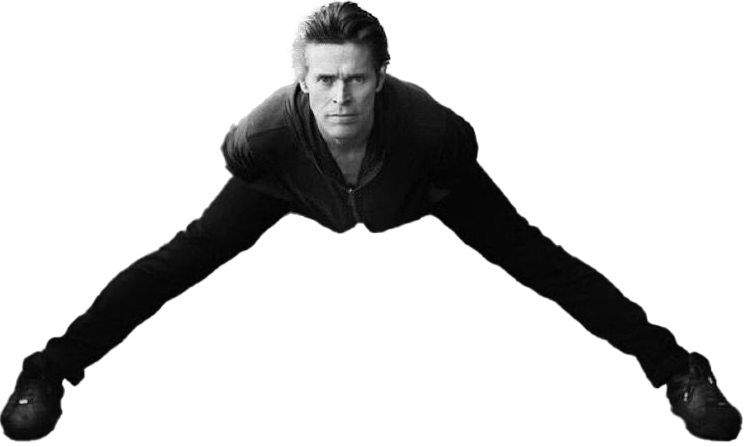

#TODO:

<br>

###Top Priority

---

####Cross-validation with both test-set and k-fold cross-validation
####Figure out what a loadings plot is
####Make a loadings plot for linear regression


---

<br>

###Second Priority

---


####Cast data_year columns to int
####Figure out why ethnicity_race_cols are converted to np.nan instead of float values
####Stop dropping other data years from county_demo_df
####Replace Anti-Church of Jesus Christ bias with Anti-Mormon
####Add county demographic data from other years
####Get f-values for in merged_df?

#Import and Config

##Import all libraries

In [1]:
# Basics
import numpy as np
import re
import warnings


# Pandas
import pandas as pd


# Scikit-Learn
import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
# Classifiers
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB



# Plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt

##Config

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
minimum_categorical_positive_count = 5
default_z_threshold_for_outliers = 2.5
# years to draw crime data from
years = [i for i in range(2010, 2020)] + [2021, 2022]
county_replacement_map = {
    "-": "Median on lower end of distribution",
    "+": "Median on upper end of distribution",
    # Number of samples too small for estimate
    "N": np.nan,
    # Estimate not applicable or not available
    "(X)": 0
}

##Import datasets

In [5]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [6]:
def drop_duplicate_cols(df, keep):
  return df.loc[:, ~df.columns.duplicated(keep=keep)]

In [7]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/hate_crime/hate_crime.csv", on_bad_lines='skip')

In [8]:
# create the county_demo_df
county_demo_df = pd.DataFrame()

# combine all datasets of the specified years
for year in years:
  temp_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/demographics/county/data/ACSDP1Y" + str(year) + ".DP05-Data.csv", on_bad_lines='skip')

  #fix the headers
  temp_df = fixHeaders(temp_df)
  temp_df["data_year"] = year

  print("Imported " + str(year))

  if county_demo_df.empty:
    county_demo_df = temp_df.copy(deep=True)
  else:
    # for some reason there are duplicates of some indicators, which I didn't see, so keep only the last of column duplicates
    county_demo_df = drop_duplicate_cols(county_demo_df, "last")
    temp_df = drop_duplicate_cols(temp_df, "last")

    # concatenate the county demographic datasets
    county_demo_df = pd.concat([county_demo_df, temp_df], ignore_index=True)

Imported 2010
Imported 2011
Imported 2012
Imported 2013
Imported 2014
Imported 2015
Imported 2016
Imported 2017
Imported 2018
Imported 2019
Imported 2021
Imported 2022


In [9]:
ethnicity_race_cols = list(set(pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/datasets/demographics/county/ethnicity_race_col_names", sep=";")["Percent!!RACE!!One race"]))
# ethnicity_race_cols

In [10]:
county_demo_df.head()

0       Geography     Geographic Area Name  \
0  0500000US01003  Baldwin County, Alabama   
1  0500000US01015  Calhoun County, Alabama   
2  0500000US01043  Cullman County, Alabama   
3  0500000US01049   DeKalb County, Alabama   
4  0500000US01051   Elmore County, Alabama   

0 Estimate!!SEX AND AGE!!Total population  \
0                                  183195   
1                                  118510   
2                                   80459   
3                                   71151   
4                                   79549   

0 Estimate Margin of Error!!SEX AND AGE!!Total population  \
0                                              *****        
1                                              *****        
2                                              *****        
3                                              *****        
4                                              *****        

0 Percent!!SEX AND AGE!!Total population  \
0                                 183195   
1                                 118510   
2                                  80459   
3                                  71151   
4                                  79549   

0 Percent Margin of Error!!SEX AND AGE!!Total population  \
0                                                (X)       
1                                                (X)       
2                                                (X)       
3                                                (X)       
4                                                (X)       

0 Estimate!!SEX AND AGE!!Under 5 years  \
0                                10991   
1                                 7381   
2                                 4817   
3                                 5011   
4                                 4871   

0 Estimate Margin of Error!!SEX AND AGE!!Under 5 years  \
0                                                521     
1                                                649     
2                                                381     
3                                                283     
4                                                246     

0 Percent!!SEX AND AGE!!Under 5 years  \
0                                 6.0   
1                                 6.2   
2                                 6.0   
3                                 7.0   
4                                 6.1   

0 Percent Margin of Error!!SEX AND AGE!!Under 5 years  \
0                                                0.3    
1                                                0.5    
2                                                0.5    
3                                                0.4    
4                                                0.3    

0 Estimate!!SEX AND AGE!!5 to 9 years  \
0                               11338   
1                                6573   
2                                4908   
3                                5352   
4                                5096   

0 Estimate Margin of Error!!SEX AND AGE!!5 to 9 years  \
0                                               1456    
1                                               1107    
2                                                769    
3                                               1128    
4                                                732    

0 Percent!!SEX AND AGE!!5 to 9 years  \
0                                6.2   
1                                5.5   
2                                6.1   
3                                7.5   
4                                6.4   

0 Percent Margin of Error!!SEX AND AGE!!5 to 9 years  \
0                                                0.8   
1                                                0.9   
2                                                1.0   
3                                                1.6   
4                                                0.9   

0 Estimate!!SEX AND AGE!!10 to 14 years  \
0                                 12758   
1            

In [11]:
county_demo_df.tail()

0          Geography                  Geographic Area Name  \
9981  0500000US72113          Ponce Municipio, Puerto Rico   
9982  0500000US72127       San Juan Municipio, Puerto Rico   
9983  0500000US72135       Toa Alta Municipio, Puerto Rico   
9984  0500000US72137       Toa Baja Municipio, Puerto Rico   
9985  0500000US72139  Trujillo Alto Municipio, Puerto Rico   

0    Estimate!!SEX AND AGE!!Total population  \
9981                                  132138   
9982                                  334776   
9983                                   66041   
9984                                   72783   
9985                                   66810   

0    Estimate Margin of Error!!SEX AND AGE!!Total population  \
9981                                                NaN        
9982                                                NaN        
9983                                                NaN        
9984                                                NaN        
9985                                                NaN        

0    Percent!!SEX AND AGE!!Total population  \
9981                                 132138   
9982                                 334776   
9983                                  66041   
9984                                  72783   
9985                                  66810   

0    Percent Margin of Error!!SEX AND AGE!!Total population  \
9981                                                (X)       
9982                                                (X)       
9983                                                (X)       
9984                                                (X)       
9985                                                (X)       

0    Estimate!!SEX AND AGE!!Under 5 years  \
9981                                  NaN   
9982                                  NaN   
9983                                  NaN   
9984                                  NaN   
9985                                  NaN   

0    Estimate Margin of Error!!SEX AND AGE!!Under 5 years  \
9981                                                NaN     
9982                                                NaN     
9983                                                NaN     
9984                                                NaN     
9985                                                NaN     

0    Percent!!SEX AND AGE!!Under 5 years  \
9981                                 NaN   
9982                                 NaN   
9983                                 NaN   
9984                                 NaN   
9985                                 NaN   

0    Percent Margin of Error!!SEX AND AGE!!Under 5 years  \
9981                                                NaN    
9982                                                NaN    
9983                                                NaN    
9984                                                NaN    
9985                                                NaN    

0    Estimate!!SEX AND AGE!!5 to 9 years  \
9981                                 NaN   
9982                                 NaN   
9983                                 NaN   
9984                                 NaN   
9985                                 NaN   

0    Estimate Margin of Error!!SEX AND AGE!!5 to 9 years  \
9981                                                NaN    
9982                                                NaN    
9983                                                NaN    
9984                                                NaN    
9985                                                NaN    

0    Percent!!SEX AND AGE!!5 to 9 years  \
9981                                NaN   
9982                                NaN   
9983                                NaN   
9984                                NaN   
9985                                NaN   

0    Percent Margin of Error!!SEX AND AGE!!5 to 9 years  \
9981                                                NaN   
9982                    

In [12]:
duplicate_cols = [x for x in county_demo_df.columns if county_demo_df.columns.tolist().count(x) > 1]
print("Duplicate columns: " + str(duplicate_cols))

Duplicate columns: []


#Data Cleaning

##Important Functions

In [13]:
def get_col_counts(df, unique_cols):
    # get the frequencies of categorical data based
    unique_col_counts = {}
    for value in unique_cols:
        if value in set(df.columns):
          unique_col_counts[value] = df[value].sum()
          # print(value)

    return unique_col_counts

In [14]:
def drop_outliers(df, numerical_cols, z_threshold=default_z_threshold_for_outliers):
    df_out = df.copy()  # Create a copy to avoid modifying the original DataFrame

    for column in numerical_cols:
        # Calculate Z-score for each value in the column
        z_scores = np.abs((df_out[column] - df_out[column].mean()) / df_out[column].std())

        print(z_scores.head())

        # Identify outliers based on Z-score
        outliers = df_out[z_scores > z_threshold]

        # Drop outliers from the DataFrame
        df_out = df_out.drop(outliers.index)

    return df_out

##Clean crime dataset

In [15]:
crime_df.head()

incident_id  data_year        ori    pug_agency_name pub_agency_unit  \
0           43       1991  AR0350100         Pine Bluff             NaN   
1           44       1991  AR0350100         Pine Bluff             NaN   
2           45       1991  AR0600300  North Little Rock             NaN   
3           46       1991  AR0600300  North Little Rock             NaN   
4           47       1991  AR0670000             Sevier             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0             City         AR   Arkansas  West South Central       South   
1             City         AR   Arkansas  West South Central       South   
2             City         AR   Arkansas  West South Central       South   
3             City         AR   Arkansas  West South Central       South   
4           County         AR   Arkansas  West South Central       South   

  population_group_code    population_group_description incident_date  \
0                     3  Cities from 50,000 thru 99,999    1991-07-04   
1                     3  Cities from 50,000 thru 99,999    1991-12-24   
2                     3  Cities from 50,000 thru 99,999    1991-07-10   
3                     3  Cities from 50,000 thru 99,999    1991-10-06   
4                    8D   Non-MSA counties under 10,000    1991-10-14   

   adult_victim_count  juvenile_victim_count  total_offender_count  \
0                 NaN                    NaN                     1   
1                 NaN                    NaN                     1   
2                 NaN                    NaN                     1   
3                 NaN                    NaN                     2   
4                 NaN                    NaN                     1   

   adult_offender_count  juvenile_offender_count              offender_race  \
0                   NaN                      NaN  Black or African American   
1                   NaN                      NaN  Black or African American   
2                   NaN                      NaN  Black or African American   
3                   NaN                      NaN  Black or African American   
4                   NaN                      NaN                      White   

  offender_ethnicity  victim_count  \
0      Not Specified             1   
1      Not Specified             2   
2      Not Specified             2   
3      Not Specified             1   
4      Not Specified             1   

                                        offense_name  \
0                                 Aggravated Assault   
1  Aggravated Assault;Destruction/Damage/Vandalis...   
2  Aggravated Assault;Murder and Nonnegligent Man...   
3                                       Intimidation   
4                                       Intimidation   

   total_individual_victims                       location_name  \
0                       1.0                      Residence/Home   
1                       1.0  Highway/Road/Alley/Street/Sidewalk   
2                       2.0                      Residence/Home   
3                       1.0                      Residence/Home   
4                       1.0                      School/College   

                        bias_desc victim_types multiple_offense multiple_bias  
0  Anti-Black or African American   Individual                S             S  
1                      Anti-White   Individual                M             S  
2                      Anti-White   Individual                M             S  
3                      Anti-White   Individual                S             S  
4  Anti-Black or African American   Individual                S             S

In [16]:
#only consider county data in scope
crime_df = crime_df[(crime_df['data_year'].isin(years)) & ((crime_df['agency_type_name'] == "County"))]

crime_df.reset_index(inplace=True)

In [17]:
crime_continuous_int_columns = ["index", "incident_id", "data_year"] + list(crime_df.select_dtypes("float64").columns)

crime_df[crime_continuous_int_columns].head()

index  incident_id  data_year  adult_victim_count  juvenile_victim_count  \
0  143544       143579       2010                 NaN                    NaN   
1  143547       143582       2010                 NaN                    NaN   
2  143555       143590       2010                 NaN                    NaN   
3  143556       143591       2010                 NaN                    NaN   
4  143557       143592       2010                 NaN                    NaN   

   adult_offender_count  juvenile_offender_count  total_individual_victims  
0                   NaN                      NaN                       1.0  
1                   NaN                      NaN                       2.0  
2                   NaN                      NaN                       1.0  
3                   NaN                      NaN                       1.0  
4                   NaN                      NaN                       1.0

In [18]:
crime_continuous_int_columns

['index',
 'incident_id',
 'data_year',
 'adult_victim_count',
 'juvenile_victim_count',
 'adult_offender_count',
 'juvenile_offender_count',
 'total_individual_victims']

###Drop outliers and bad rows

In [19]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  143544       143579       2010  AL0080000          Blount             NaN   
1  143547       143582       2010  AL0160000          Clarke             NaN   
2  143555       143590       2010  AL0630000      Tuscaloosa             NaN   
3  143556       143591       2010  AL0630000      Tuscaloosa             NaN   
4  143557       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  
0   Individual                S             S  
1   Individual                S             S  
2   Individual                S             S  
3   Individual                S             S  
4   Individual                S             S

In [20]:
# crime_df.reset_index(inplace=True)
crime_df = drop_outliers(crime_df, crime_continuous_int_columns)

0    1.579044
1    1.578942
2    1.578669
3    1.578635
4    1.578601
Name: index, dtype: float64
0    0.922841
1    0.922836
2    0.922823
3    0.922822
4    0.922820
Name: incident_id, dtype: float64
0    1.576171
1    1.576171
2    1.576171
3    1.576171
4    1.576171
Name: data_year, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: adult_victim_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: juvenile_victim_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: adult_offender_count, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: juvenile_offender_count, dtype: float64
0    0.035438
1    0.894430
2    0.035438
3    0.035438
4    0.035438
Name: total_individual_victims, dtype: float64


In [21]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  143544       143579       2010  AL0080000          Blount             NaN   
1  143547       143582       2010  AL0160000          Clarke             NaN   
2  143555       143590       2010  AL0630000      Tuscaloosa             NaN   
3  143556       143591       2010  AL0630000      Tuscaloosa             NaN   
4  143557       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  
0   Individual                S             S  
1   Individual                S             S  
2   Individual                S             S  
3   Individual                S             S  
4   Individual                S             S

###Break up incident date information

In [22]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"]\
                                                              .map(split_incident_date)\
                                                              .apply(pd.Series)\
                                                              .astype(int)

In [23]:
crime_df[["data_year", "incident_month", "incident_day"]].dtypes

data_year         int64
incident_month    int64
incident_day      int64
dtype: object

###Break up crime_df categorical columns containing multiple categories into dummies

In [24]:
def multicol_parse(df, column, delimiter):
  prefix = column + "_"

  dummies = df[column]\
              .str\
              .get_dummies(sep=delimiter)\
              .add_prefix(prefix)
  dummies = dummies.astype(int)
  dummies.head()

  dummy_cols = list(dummies.columns)
  unique_values = [val.replace(prefix, "") for val in dummy_cols]

  # combine the dataframes
  new_df = pd.concat([df, dummies], axis=1)

  return unique_values, dummy_cols, new_df

In [25]:
crime_df.reset_index(inplace=True)

In [26]:
#Break up bias_desc column into dummy columns
unique_biases, bias_cols, crime_df = multicol_parse(crime_df, "bias_desc", ";")

In [27]:
#Break up victim_types column into dummy columns
unique_victim_types, victim_cols, crime_df = multicol_parse(crime_df, "victim_types", ";")

In [28]:
#Break up offense_names column into dummy columns
unique_offense_names, offense_cols, crime_df = multicol_parse(crime_df, "offense_name", ";")

In [29]:
#Break up location_names column into dummy columns
unique_location_names, location_cols, crime_df = multicol_parse(crime_df, "location_name", ";")

###Create dummy columns for other categorical variables

In [30]:
other_categorical_cols = ["pug_agency_name", "agency_type_name", "division_name", "offender_race",
                          "offender_ethnicity", "state_name", "multiple_offense", "multiple_bias"]

In [31]:
other_categorical_cols

['pug_agency_name',
 'agency_type_name',
 'division_name',
 'offender_race',
 'offender_ethnicity',
 'state_name',
 'multiple_offense',
 'multiple_bias']

In [32]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  143544       143579       2010  AL0080000          Blount   
1        1  143547       143582       2010  AL0160000          Clarke   
2        2  143555       143590       2010  AL0630000      Tuscaloosa   
3        3  143556       143591       2010  AL0630000      Tuscaloosa   
4        4  143557       143592       2010  AL0630000      Tuscaloosa   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9B      MSA counties from 25,000 thru 99,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    9B      MSA counties from 25,000 thru 99,999   
3       South                    9B      MSA counties from 25,000 thru 99,999   
4       South                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  incident_month  incident_day  \
0   Individual                S             S               6             3   
1   Individual                S             S               2            18   
2   Individual                S             S               9             1   
3   Individual                S             S               6            16   
4   Individual                S             S               6            16   

   bias_desc_Anti-American Indian or Alaska Native  bias_d

In [33]:
other_unique_categorical_cols = {}
for col in other_categorical_cols:
    unique_values = crime_df[col].unique()
    # print(unique_values)
    other_unique_categorical_cols[col] = [col + "_" + str(val) for val in unique_values]
print(other_unique_categorical_cols["pug_agency_name"])

['pug_agency_name_Blount', 'pug_agency_name_Clarke', 'pug_agency_name_Tuscaloosa', 'pug_agency_name_Benton', 'pug_agency_name_Garland', 'pug_agency_name_Independence', 'pug_agency_name_Lonoke', 'pug_agency_name_Pulaski', 'pug_agency_name_Perry', 'pug_agency_name_White', 'pug_agency_name_Maricopa', 'pug_agency_name_Pima', 'pug_agency_name_Pinal', 'pug_agency_name_Butte', 'pug_agency_name_Contra Costa', 'pug_agency_name_Kern', 'pug_agency_name_Lake', 'pug_agency_name_Los Angeles', 'pug_agency_name_Madera', 'pug_agency_name_Mendocino', 'pug_agency_name_Orange', 'pug_agency_name_Riverside', 'pug_agency_name_Sacramento', 'pug_agency_name_San Bernardino', 'pug_agency_name_San Diego', 'pug_agency_name_Santa Barbara', 'pug_agency_name_Santa Clara', 'pug_agency_name_Santa Cruz', 'pug_agency_name_Shasta', 'pug_agency_name_Stanislaus', 'pug_agency_name_Sonoma', 'pug_agency_name_Colusa', 'pug_agency_name_El Dorado', 'pug_agency_name_San Joaquin', 'pug_agency_name_Mariposa', 'pug_agency_name_Monter

In [34]:
dummies = pd.get_dummies(crime_df[other_categorical_cols]).astype(int)
dummies.drop(columns=['multiple_offense_S', 'multiple_bias_S'], inplace=True)
other_unique_categorical_cols["multiple_offense"] = ["multiple_offense_M"]
other_unique_categorical_cols["multiple_bias"] = ["multiple_bias_M"]

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

###List the categorical columns

In [35]:
# break up other_unique_categorical_cols because Python is being stupid
crime_categorical_cols = bias_cols\
                          + victim_cols\
                          + offense_cols\
                          + location_cols
for key, value in other_unique_categorical_cols.items():
  crime_categorical_cols += value

###Drop new bad columns

In [36]:
crime_df.drop(["level_0", "index"], axis=1, inplace=True)

##Clean county demographic dataset

In [37]:
# Set of header prefixes to remove
removalSet = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

county_str_cols = ["Geography", "Geographic Area Name", "pug_agency_name", "agency_type_name", "state_name"]

# continuous quantitative variables
county_continuous_int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years",\
                                 "10 to 14 years", "75 to 84 years", "60 to 64 years", "25 to 34 years",\
                                 "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years",\
                                 "65 to 74 years", "85 years and over"]

# age groups for the final df
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years','15 to 19 years',\
              '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years',\
              '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years',\
              '85 years and over']

county_numerical_cols = list(set(county_demo_df.columns).difference(set(county_str_cols)))

In [38]:
county_demo_df.head()

0       Geography     Geographic Area Name  \
0  0500000US01003  Baldwin County, Alabama   
1  0500000US01015  Calhoun County, Alabama   
2  0500000US01043  Cullman County, Alabama   
3  0500000US01049   DeKalb County, Alabama   
4  0500000US01051   Elmore County, Alabama   

0 Estimate!!SEX AND AGE!!Total population  \
0                                  183195   
1                                  118510   
2                                   80459   
3                                   71151   
4                                   79549   

0 Estimate Margin of Error!!SEX AND AGE!!Total population  \
0                                              *****        
1                                              *****        
2                                              *****        
3                                              *****        
4                                              *****        

0 Percent!!SEX AND AGE!!Total population  \
0                                 183195   
1                                 118510   
2                                  80459   
3                                  71151   
4                                  79549   

0 Percent Margin of Error!!SEX AND AGE!!Total population  \
0                                                (X)       
1                                                (X)       
2                                                (X)       
3                                                (X)       
4                                                (X)       

0 Estimate!!SEX AND AGE!!Under 5 years  \
0                                10991   
1                                 7381   
2                                 4817   
3                                 5011   
4                                 4871   

0 Estimate Margin of Error!!SEX AND AGE!!Under 5 years  \
0                                                521     
1                                                649     
2                                                381     
3                                                283     
4                                                246     

0 Percent!!SEX AND AGE!!Under 5 years  \
0                                 6.0   
1                                 6.2   
2                                 6.0   
3                                 7.0   
4                                 6.1   

0 Percent Margin of Error!!SEX AND AGE!!Under 5 years  \
0                                                0.3    
1                                                0.5    
2                                                0.5    
3                                                0.4    
4                                                0.3    

0 Estimate!!SEX AND AGE!!5 to 9 years  \
0                               11338   
1                                6573   
2                                4908   
3                                5352   
4                                5096   

0 Estimate Margin of Error!!SEX AND AGE!!5 to 9 years  \
0                                               1456    
1                                               1107    
2                                                769    
3                                               1128    
4                                                732    

0 Percent!!SEX AND AGE!!5 to 9 years  \
0                                6.2   
1                                5.5   
2                                6.1   
3                                7.5   
4                                6.4   

0 Percent Margin of Error!!SEX AND AGE!!5 to 9 years  \
0                                                0.8   
1                                                0.9   
2                                                1.0   
3                                                1.6   
4                                                0.9   

0 Estimate!!SEX AND AGE!!10 to 14 years  \
0                                 12758   
1            

###Create area columns

In [39]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [40]:
splitArea(county_demo_df)

###Fix column names



In [41]:
def fix_column_names(df):

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalSet:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_column_names(county_demo_df)

###Remove irrelevant/bad columns and rows to line the dataframes up

In [42]:
#drop all margin of error columns from the county dataframe
def drop_cols_containing(df, pattern):
    df.drop(columns=list(df.filter(regex = pattern)), inplace = True)

drop_cols_containing(county_demo_df, "Margin of Error|SUMMARY INDICATORS|PERCENT ALLOCATED")

In [43]:
# Drop columns that only contain NaN values
new_county_df = county_demo_df.dropna(how='all', axis=1)

# get a list of the cols in the original df that aren't in the new one
dropped_cols = (set(county_demo_df.columns)).difference(set(new_county_df.columns))

# remove the deleted columns from ethnicity_race_cols
ethnicity_race_cols = list((set(ethnicity_race_cols)).difference(set(dropped_cols)))

county_demo_df = new_county_df

print(ethnicity_race_cols)

['Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone', 'Percent!!RACE!!One race!!Asian!!Filipino', 'Percent!!RACE!!One race!!Asian', 'Percent!!RACE!!Two or More Races!!Black or African American and American Indian and Alaska Native', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!White alone', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Black or African American alone', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races', 'Percent!!Total housing units', 'Percent!!RACE!!One race!!White', 'Percent!!Race alone or in combination with one or more other races!!Black or African American', 'Percent!!RACE!!Two or More Races!!White and American Indian and Alaska Native', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race', 'Percent!!RACE!!One race!!Native Hawaiian and Othe

In [44]:
print(len(county_numerical_cols))
print(len(county_demo_df.columns))

903
457


In [45]:
#drop duplicate columns, keeping only the last one
county_demo_df = drop_duplicate_cols(county_demo_df, "last")

#update the county_numerical_cols to exclude any dropped columns
county_numerical_cols = list(set(county_numerical_cols).intersection(set(county_demo_df.columns)))

In [46]:
print(len(county_numerical_cols))
print(len(county_demo_df.columns))

54
317


In [57]:
# fix any data indicated in county_replacement_map
for original, replacement in county_replacement_map.items():
  county_demo_df[county_numerical_cols] = county_demo_df[county_numerical_cols].replace(original, replacement)

In [58]:
# Drop rows with NaN values in all of the ethnicity_race_cols
county_demo_df.dropna(subset=ethnicity_race_cols, how='all', inplace=True)

# replace missing ethnicity/race data with 0's;
#   ie if there were too few samples to estimate a certain ethnicity/race population/percentage, round to 0
county_demo_df[county_numerical_cols] = county_demo_df[county_numerical_cols].fillna(value=0)

In [62]:
county_demo_df.head()

Geography     Geographic Area Name Total population  \
0  0500000US01003  Baldwin County, Alabama           183195   
1  0500000US01015  Calhoun County, Alabama           118510   
2  0500000US01043  Cullman County, Alabama            80459   
3  0500000US01049   DeKalb County, Alabama            71151   
4  0500000US01051   Elmore County, Alabama            79549   

  Percent!!Total population RACE!!Total population  \
0                    183195                 183195   
1                    118510                 118510   
2                     80459                  80459   
3                     71151                  71151   
4                     79549                  79549   

   Percent!!RACE!!Total population  \
0                         183195.0   
1                         118510.0   
2                          80459.0   
3                          71151.0   
4                          79549.0   

  RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                             183195                                  
1                                             118510                                  
2                                              80459                                  
3                                              71151                                  
4                                              79549                                  

   Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                           183195.0                                            
1                                           118510.0                                            
2                                            80459.0                                            
3                                            71151.0                                            
4                                            79549.0                                            

  RACE!!White  Percent!!RACE!!White RACE!!Black or African American  \
0      162119                  88.5                           18068   
1       89517                  75.5                           25510   
2       77999                  96.9                            1596   
3       66804                  93.9                            2158   
4       61869                  77.8                           16499   

   Percent!!RACE!!Black or African American  \
0                                       9.9   
1                                      21.5   
2                                       2.0   
3                                       3.0   
4                                      20.7   

  RACE!!American Indian and Alaska Native  \
0                                    2360   
1                                     972   
2                                     863   
3                                    2182   
4                                     858   

   Percent!!RACE!!American Indian and Alaska Native RACE!!Asian  \
0                                               1.3        1740   
1                                               0.8        1086   
2                                               1.1           N   
3                                               3.1           N   
4                                               1.1         817   

   Percent!!RACE!!Asian RACE!!Native Hawaiian and Other Pacific Islander  \
0                   0.9                                                N   
1                   0.9                                                N   
2                   0.0                                                N   
3                   0.0                                                N   
4                   1.0                                                N   

   Percent!!RACE!!Native Hawaiian and Other Pacific Islander  \
0                                                0.0           


###Fix column data types

In [65]:
county_demo_df[county_numerical_cols] = county_demo_df[county_numerical_cols].astype(float)

In [66]:
county_demo_df[ethnicity_race_cols] = county_demo_df[ethnicity_race_cols].astype(float)

In [67]:
# Convert the quantitative columns to int types
county_demo_df[county_continuous_int_columns] = county_demo_df[county_continuous_int_columns].astype(int)

###Drop outliers

In [68]:
# county_demo_df = drop_outliers(county_demo_df, county_continuous_int_columns + ethnicity_race_cols)

#Data Quality Check

##County demographics

In [69]:
county_demo_df.head()

Geography     Geographic Area Name  Total population  \
0  0500000US01003  Baldwin County, Alabama            183195   
1  0500000US01015  Calhoun County, Alabama            118510   
2  0500000US01043  Cullman County, Alabama             80459   
3  0500000US01049   DeKalb County, Alabama             71151   
4  0500000US01051   Elmore County, Alabama             79549   

  Percent!!Total population RACE!!Total population  \
0                    183195                 183195   
1                    118510                 118510   
2                     80459                  80459   
3                     71151                  71151   
4                     79549                  79549   

   Percent!!RACE!!Total population  \
0                         183195.0   
1                         118510.0   
2                          80459.0   
3                          71151.0   
4                          79549.0   

  RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                             183195                                  
1                                             118510                                  
2                                              80459                                  
3                                              71151                                  
4                                              79549                                  

   Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                           183195.0                                            
1                                           118510.0                                            
2                                            80459.0                                            
3                                            71151.0                                            
4                                            79549.0                                            

  RACE!!White  Percent!!RACE!!White RACE!!Black or African American  \
0      162119                  88.5                           18068   
1       89517                  75.5                           25510   
2       77999                  96.9                            1596   
3       66804                  93.9                            2158   
4       61869                  77.8                           16499   

   Percent!!RACE!!Black or African American  \
0                                       9.9   
1                                      21.5   
2                                       2.0   
3                                       3.0   
4                                      20.7   

  RACE!!American Indian and Alaska Native  \
0                                    2360   
1                                     972   
2                                     863   
3                                    2182   
4                                     858   

   Percent!!RACE!!American Indian and Alaska Native RACE!!Asian  \
0                                               1.3        1740   
1                                               0.8        1086   
2                                               1.1           N   
3                                               3.1           N   
4                                               1.1         817   

   Percent!!RACE!!Asian RACE!!Native Hawaiian and Other Pacific Islander  \
0                   0.9                                                N   
1                   0.9                                                N   
2                   0.0                                                N   
3                   0.0                                                N   
4                   1.0                                                N   

   Percent!!RACE!!Native Hawaiian and Other Pacific Islander  \
0                                                0.0      

In [104]:
print("There are " + str(county_demo_df.size) + " county data entries")

There are 3732384 county data entries


In [70]:
county_demo_df["data_year"].unique()

array([2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2019.,
       2021., 2022.])

In [71]:
#get the total number of np.nan values
nan_counts = county_demo_df.isnull().sum()
#  ...and the columns associated with them
nan_cols = [col for col in county_demo_df.columns if nan_counts[col] > 0]
nan_counts.loc[nan_cols]

RACE!!Race alone or in combination with one or more other races!!Total population                                                               2529
RACE!!White                                                                                                                                     6683
RACE!!Black or African American                                                                                                                 6683
RACE!!American Indian and Alaska Native                                                                                                         6683
RACE!!Asian                                                                                                                                     6683
RACE!!Native Hawaiian and Other Pacific Islander                                                                                                6683
RACE!!Some other race                                                                                     

##Crime df

In [72]:
crime_df.head()

incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0       143579       2010  AL0080000          Blount             NaN   
1       143582       2010  AL0160000          Clarke             NaN   
2       143590       2010  AL0630000      Tuscaloosa             NaN   
3       143591       2010  AL0630000      Tuscaloosa             NaN   
4       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  incident_month  incident_day  \
0   Individual                S             S               6             3   
1   Individual                S             S               2            18   
2   Individual                S             S               9             1   
3   Individual                S             S               6            16   
4   Individual                S             S               6            16   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1         

In [73]:
#get the total number of np.nan values
nan_counts = crime_df.isnull().sum()
#  ...and the columns associated with them
nan_cols = [col for col in crime_df.columns if nan_counts[col] > 0]
nan_counts.loc[nan_cols]

pub_agency_unit             11581
adult_victim_count           3332
juvenile_victim_count        3379
adult_offender_count         4482
juvenile_offender_count      4484
total_individual_victims      320
dtype: int64

In [74]:
# crime_df.dtypes

#Data Engineering

##Perform power transformations and normalize data

###Transform data to Gaussian distributions

In [75]:
def transform_standardize_data(df, numerical_cols, categorical_cols):
  # increase subsampling size if df is bigger than the default size
  n_quantiles = len(df)
  subsample = 10000
  if n_quantiles > subsample:
    subsample = n_quantiles * 10

  print("Performing quantile transformation process...")
  # use a quantile transformer to normalize the data and since the PowerTransformer keeps shitting itself
  scaler = sk.preprocessing.QuantileTransformer(output_distribution="normal", n_quantiles=n_quantiles, subsample=subsample)
  transformed_data = scaler.fit_transform(df[numerical_cols])

  print("Renaming numerical columns...")
  for i, col in enumerate(numerical_cols):
    new_column_header = "transformed_" + col

    # update the list of numerical column labels
    numerical_cols[i] = new_column_header
    # add the transformed, standardized data back to the original dataframe
    df[new_column_header] = transformed_data[:, i]

  print("Dropping categorical columns with insufficient sample size...")
  # identify columns with insufficient sample sizes
  columns_to_drop = []
  for col in categorical_cols:
      if df[col].sum() < minimum_categorical_positive_count:
          columns_to_drop.append(col)

  # drop identified columns
  df.drop(columns_to_drop, axis=1, inplace=True)

  # update categorical_cols after dropping
  categorical_cols = [col for col in categorical_cols if col not in columns_to_drop]

In [76]:
crime_numerical_cols = list(crime_df.select_dtypes(include=['int64', 'float64']).columns)
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)

In [77]:
# yeo-johnson transformation is super brittle and I'm not sure why
#transform the county data
transform_standardize_data(county_demo_df, county_numerical_cols, [])

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


In [78]:
#transform the non-categorical data of crime_df
transform_standardize_data(crime_df,\
                            [col for col in crime_numerical_cols\
                                      if not col in crime_categorical_cols],\
                            crime_categorical_cols)

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


In [79]:
# remove columns that were removed from crime_df due to insufficient sample size from consideration
county_numerical_cols = [col for col in county_numerical_cols if col in set(county_demo_df.columns)]

# remove columns that were removed from crime_df due to insufficient sample size from consideration
crime_numerical_cols = [col for col in crime_numerical_cols if col in set(crime_df.columns)]

In [80]:
print(crime_numerical_cols)

['incident_id', 'data_year', 'adult_victim_count', 'juvenile_victim_count', 'total_offender_count', 'adult_offender_count', 'juvenile_offender_count', 'victim_count', 'total_individual_victims', 'incident_month', 'incident_day', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Arab', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Atheism/Agnosticism', 'bias_desc_Anti-Bisexual', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-Buddhist', 'bias_desc_Anti-Catholic', 'bias_desc_Anti-Church of Jesus Christ', 'bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)', 'bias_desc_Anti-Female', 'bias_desc_Anti-Gay (Male)', 'bias_desc_Anti-Gender Non-Conforming', 'bias_desc_Anti-Heterosexual', 'bias_desc_Anti-Hindu', 'bias_desc_Anti-Hispanic or Latino', 'bias_desc_Anti-Islamic (Muslim)', "bias_desc_Anti-Jehovah's Witness", 'bias_desc_Anti-Jewish', 'bias_desc_Anti-Lesbian (Female)', 'bias_desc_Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)', 'bias_desc_Anti-Male',

In [81]:
# [col for col in crime_numerical_cols if not col in crime_categorical_cols]

##Extract additional features from the data

####Get hate crime rate per county

In [82]:
crime_df.head()

incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0       143579       2010  AL0080000          Blount             NaN   
1       143582       2010  AL0160000          Clarke             NaN   
2       143590       2010  AL0630000      Tuscaloosa             NaN   
3       143591       2010  AL0630000      Tuscaloosa             NaN   
4       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  incident_month  incident_day  \
0   Individual                S             S               6             3   
1   Individual                S             S               2            18   
2   Individual                S             S               9             1   
3   Individual                S             S               6            16   
4   Individual                S             S               6            16   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1         

#####Get list of counties in the hate crime database

In [83]:
# print(set([col for col in crime_df.columns if "pug_agency_name" in col]))

# Remove agencies that were dropped from the list of unique categorical columns
other_unique_categorical_cols["pug_agency_name"] = list((set(other_unique_categorical_cols["pug_agency_name"])).intersection(set(crime_df.columns)))
# print(other_unique_categorical_cols["pug_agency_name"])

In [84]:
print(other_unique_categorical_cols)

{'pug_agency_name': ['pug_agency_name_Columbiana', 'pug_agency_name_San Juan', 'pug_agency_name_Gibson', 'pug_agency_name_Boulder', 'pug_agency_name_Frederick', 'pug_agency_name_Clark', 'pug_agency_name_Skagit', 'pug_agency_name_Brown', 'pug_agency_name_Flathead', 'pug_agency_name_Buncombe', 'pug_agency_name_Tipton', 'pug_agency_name_Gloucester', 'pug_agency_name_Pitt', 'pug_agency_name_Escambia', 'pug_agency_name_San Bernardino', 'pug_agency_name_Dinwiddie', 'pug_agency_name_Mesa', 'pug_agency_name_Sumner', 'pug_agency_name_Warren', 'pug_agency_name_Kauai Police Department', 'pug_agency_name_Stone', 'pug_agency_name_Gratiot', 'pug_agency_name_Androscoggin', 'pug_agency_name_Grand Forks', 'pug_agency_name_Butte-Silver Bow', 'pug_agency_name_Will', 'pug_agency_name_Los Angeles', 'pug_agency_name_Bradley', 'pug_agency_name_Pinal', 'pug_agency_name_Portage', 'pug_agency_name_Amelia', 'pug_agency_name_James City County Police Department', 'pug_agency_name_Dutchess', 'pug_agency_name_Nassau

In [85]:
county_hate_counts = get_col_counts(crime_df, other_unique_categorical_cols["pug_agency_name"])
county_hate_rates_df = pd.DataFrame.from_dict(data=county_hate_counts, orient='index', columns=['hate_crime_count'])

#####Clean dataframe

In [86]:
county_hate_rates_df["pug_agency_name"] = county_hate_rates_df\
                                            .index\
                                            .str\
                                            .replace("pug_agency_name_", "")

In [87]:
county_hate_rates_df["pug_agency_name"].head()

pug_agency_name_Columbiana    Columbiana
pug_agency_name_San Juan        San Juan
pug_agency_name_Gibson            Gibson
pug_agency_name_Boulder          Boulder
pug_agency_name_Frederick      Frederick
Name: pug_agency_name, dtype: object

In [88]:
# only include demographic info related to each of the counties in the crime dataset
filtered_county_demo_df = county_demo_df[(county_demo_df["pug_agency_name"]).isin(county_hate_rates_df["pug_agency_name"])]
filtered_county_demo_df["Geography"].count()

5164

In [89]:
# merge the 2 datasets
county_hate_rates_df = county_hate_rates_df.merge(filtered_county_demo_df, on="pug_agency_name", how="outer")

In [90]:
county_hate_rates_df = county_hate_rates_df.dropna(subset=['Geography'])

#####Get hate crime rates

In [91]:
county_hate_rates_df["hate_crime_rate"] = county_hate_rates_df["hate_crime_count"]\
                                            .divide(county_hate_rates_df["Total population"])\
                                            .astype("float64")

In [92]:
county_hate_rates_df.dropna(axis=1, how="all", inplace=True)

In [93]:
county_hate_rates_df.head()

hate_crime_count pug_agency_name       Geography     Geographic Area Name  \
0                10      Columbiana  0500000US39029  Columbiana County, Ohio   
1                10      Columbiana  0500000US39029  Columbiana County, Ohio   
2                10      Columbiana  0500000US39029  Columbiana County, Ohio   
3                10      Columbiana  0500000US39029  Columbiana County, Ohio   
4                10      Columbiana  0500000US39029  Columbiana County, Ohio   

   Total population Percent!!Total population RACE!!Total population  \
0          107800.0                    107800                 107800   
1          107570.0                    107570                 107570   
2          106507.0                    106507                 106507   
3          105893.0                    105893                 105893   
4          105686.0                    105686                 105686   

   Percent!!RACE!!Total population  \
0                         107800.0   
1                         107570.0   
2                         106507.0   
3                         105893.0   
4                         105686.0   

  RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                             107800                                  
1                                             107570                                  
2                                             106507                                  
3                                             105893                                  
4                                             105686                                  

   Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                           107800.0                                            
1                                           107570.0                                            
2                                           106507.0                                            
3                                           105893.0                                            
4                                           105686.0                                            

  RACE!!White  Percent!!RACE!!White RACE!!Black or African American  \
0      104129                  96.6                            2952   
1      103852                  96.5                            3702   
2      103145                  96.8                            3597   
3         NaN                   0.0                             NaN   
4         NaN                   0.0                             NaN   

   Percent!!RACE!!Black or African American  \
0                                       2.7   
1                                       3.4   
2                                       3.4   
3                                       0.0   
4                                       0.0   

  RACE!!American Indian and Alaska Native  \
0                                     232   
1                                       N   
2                                     529   
3                                     NaN   
4                                     NaN   

   Percent!!RACE!!American Indian and Alaska Native RACE!!Asian  \
0                                               0.2         806   
1                                               0.0         404   
2                                               0.5           N   
3                                               0.0         NaN   
4                                               0.0         NaN   

   Percent!!RACE!!Asian RACE!!Native Hawaiian and Other Pacific Islander  \
0                   0.7                                                N   
1                   0.4                                                N   
2                   0.0                                                N   
3                   0.0                                           

<Axes: ylabel='Frequency'>

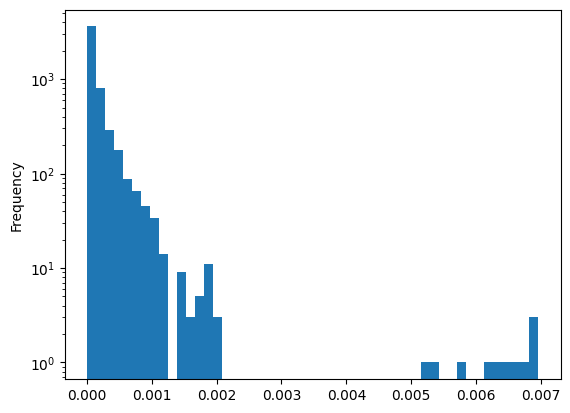

In [94]:
county_hate_rates_df["hate_crime_rate"].plot.hist(bins=50, logy=True)

####Create a categorical variable for classification testing

In [95]:
crime_df["region_name"].unique()

array(['South', 'West', 'Midwest', 'Northeast'], dtype=object)

In [96]:
county_hate_rates_df["region"] = crime_df["region_name"].map({"South":3, "West":2, "Midwest":1, "Northeast":0})

####Transform and normalize the data

In [97]:
hate_features = ["hate_crime_count", "hate_crime_rate"]

# save the hate feature data for adding back later
hate_crime_rates_df = county_hate_rates_df[hate_features]

In [98]:
# transform the hate_crime_rate data
transform_standardize_data(county_hate_rates_df, hate_features + ["region"], [])

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


<Axes: ylabel='Frequency'>

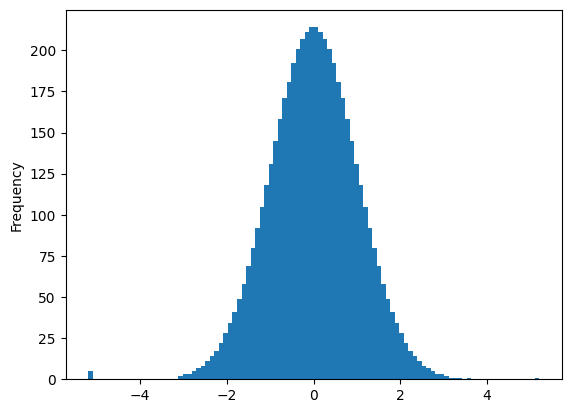

In [99]:
county_hate_rates_df['transformed_hate_crime_rate'].plot.hist(bins=100)

In [107]:
# add the original hate rates back to the county_hate_rates_df
county_hate_rates_df = pd.concat([county_hate_rates_df, hate_crime_rates_df], axis=1, join="outer")

In [108]:
hate_rate_numerical_cols = [col for col in county_hate_rates_df\
                              .select_dtypes(include=["int64", "float64"])\
                              .columns if (("transformed" in col)\
                                           or (col in hate_features))]

county_hate_rates_df = county_hate_rates_df[hate_rate_numerical_cols]

In [109]:
county_hate_rates_df.fillna(value=0, inplace=True)

##Merge the datasets

In [110]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, county_demo_df, on=["pug_agency_name", "agency_type_name", "state_name", "data_year"], how="inner")

In [111]:
merged_df.drop(other_unique_categorical_cols["pug_agency_name"] + ["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit", "pug_agency_name",
                "agency_type_name", "state_name", "division_name", "offender_race", "offender_ethnicity",
                "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"], axis=1, inplace=True)

In [112]:
merged_df.dropna(axis=1, how="all", inplace=True)

In [113]:
merged_df.head()

incident_id  data_year region_name  adult_victim_count  \
0       143590       2010       South                 NaN   
1       143591       2010       South                 NaN   
2       143592       2010       South                 NaN   
3       143593       2010       South                 NaN   
4       143594       2010       South                 NaN   

   juvenile_victim_count  total_offender_count  adult_offender_count  \
0                    NaN                     1                   NaN   
1                    NaN                     1                   NaN   
2                    NaN                     1                   NaN   
3                    NaN                     0                   NaN   
4                    NaN                     1                   NaN   

   juvenile_offender_count  victim_count    offense_name  \
0                      NaN             1    Intimidation   
1                      NaN             1  Simple Assault   
2                      NaN             1  Simple Assault   
3                      NaN             1    Intimidation   
4                      NaN             1  Simple Assault   

   total_individual_victims  incident_month  incident_day  \
0                       1.0               9             1   
1                       1.0               6            16   
2                       1.0               6            16   
3                       1.0               4             5   
4                       1.0               4             2   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1                                                0                    0   
2                                                0                    0   
3                                                0                    0   
4                                                0                    0   

   bias_desc_Anti-Asian  bias_desc_Anti-Atheism/Agnosticism  \
0                     0                                   0   
1                     0                                   0   
2                     0                                   0   
3                     0                                   0   
4                     0                                   0   

   bias_desc_Anti-Bisexual  bias_desc_Anti-Black or African American  \
0                        0                                         1   
1                        0                                         0   
2                        0                                         1   
3                        0                                         1   
4                        0                                         1   

   bias_desc_Anti-Buddhist  bias_desc_Anti-Catholic  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   

   bias_desc_Anti-Church of Jesus Christ  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   bias_desc_Anti-Female  bias_desc_Anti-Gay (Male)  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      

#Data Exploration

##Important Functions

In [114]:
def get_sorted_corrs(corr):
  # Unstack and rename corr
  corr_sorted = pd.DataFrame(corr.unstack()).reset_index()
  corr_sorted.columns = ["feature1", "feature2", "corr"]

  # Get highest correlation coefficient pairs
  corr_sorted["abs_corr"] = corr_sorted["corr"].abs()
  corr_sorted.sort_values(by="abs_corr", ascending=False, inplace=True)

  #reset the indices
  corr_sorted.reset_index(inplace=True)

  #filter out self-correlations
  corr_sorted = corr_sorted[~(corr_sorted["feature1"] == corr_sorted["feature2"])]

  #filter out stray index rows
  corr_sorted = corr_sorted[~corr_sorted["feature1"].str.contains("level_0|index")]
  corr_sorted = corr_sorted[~corr_sorted["feature2"].str.contains("level_0|index")]

  # remove duplicates
  # only keep even-numbered rows, since there will be 2 of every correlation
  corr_sorted = corr_sorted.iloc[::2]
  # corr_sorted = corr_sorted.dropna().groupby("feature1")

  return corr_sorted

In [115]:
def do_corr_analysis(corr, minThreshold, maxThreshold, blacklistPhraseRegex, corr_sorted=None):
    # get the sorted correlation coefficients
    if corr_sorted is None:
      sorted_corrs = get_sorted_corrs(corr)
    else:
      sorted_corrs = corr_sorted

    # create subplot display
    fig, ax = plt.subplots(3, figsize=(10, 20))

    # plot stuff
    sorted_corrs["corr"].plot.hist(bins=40, logy=True, ax=ax[0], title="Correlation Coefficients")
    sorted_corrs["abs_corr"].plot.hist(bins=40, logy=True, ax=ax[1], title="Correlation Coefficients' Absolute Values")

    # filter down to correlations of interest
    corrs_of_interest = sorted_corrs[(sorted_corrs["abs_corr"] > minThreshold) & (sorted_corrs["abs_corr"] < maxThreshold)
                                      & (~sorted_corrs["feature1"].str.contains(blacklistPhraseRegex))
                                      & (~sorted_corrs["feature2"].str.contains(blacklistPhraseRegex))]

    # plot the remaining correlations
    corrs_of_interest["corr"].plot.hist(bins=50, logy=True, ax=ax[2], title="Correlation Coefficients of Interest")

    return sorted_corrs, corrs_of_interest

##Individual Datasets

###Hate Crime Dataset

In [116]:
crime_df.head()

incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0       143579       2010  AL0080000          Blount             NaN   
1       143582       2010  AL0160000          Clarke             NaN   
2       143590       2010  AL0630000      Tuscaloosa             NaN   
3       143591       2010  AL0630000      Tuscaloosa             NaN   
4       143592       2010  AL0630000      Tuscaloosa             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9B      MSA counties from 25,000 thru 99,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    9B      MSA counties from 25,000 thru 99,999   
3                    9B      MSA counties from 25,000 thru 99,999   
4                    9B      MSA counties from 25,000 thru 99,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2010-06-03                 NaN                    NaN   
1    2010-02-18                 NaN                    NaN   
2    2010-09-01                 NaN                    NaN   
3    2010-06-16                 NaN                    NaN   
4    2010-06-16                 NaN                    NaN   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     1                   NaN                      NaN   
1                     4                   NaN                      NaN   
2                     1                   NaN                      NaN   
3                     1                   NaN                      NaN   
4                     1                   NaN                      NaN   

               offender_race offender_ethnicity  victim_count  \
0                      White      Not Specified             1   
1  Black or African American      Not Specified             2   
2                      White      Not Specified             1   
3  Black or African American      Not Specified             1   
4                      White      Not Specified             1   

                           offense_name  total_individual_victims  \
0                          Intimidation                       1.0   
1  Murder and Nonnegligent Manslaughter                       2.0   
2                          Intimidation                       1.0   
3                        Simple Assault                       1.0   
4                        Simple Assault                       1.0   

                        location_name                       bias_desc  \
0                      Residence/Home         Anti-Hispanic or Latino   
1                      Residence/Home             Anti-Other Religion   
2  Highway/Road/Alley/Street/Sidewalk  Anti-Black or African American   
3                      Residence/Home                      Anti-White   
4                      Residence/Home  Anti-Black or African American   

  victim_types multiple_offense multiple_bias  incident_month  incident_day  \
0   Individual                S             S               6             3   
1   Individual                S             S               2            18   
2   Individual                S             S               9             1   
3   Individual                S             S               6            16   
4   Individual                S             S               6            16   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1         

####Correlation matrix

In [117]:
for item in ['level_0', 'index', 'incident_id', 'data_year']:
  if item in crime_numerical_cols:
    crime_numerical_cols.remove(item)

In [118]:
# Create a correlation matrix
crime_corr = crime_df[crime_numerical_cols].dropna().corr()

In [119]:
# # Set the figure size
# plt.figure(figsize=(200, 100))

# # Create a heatmap of the correlation matrix
# sns.heatmap(crime_corr, annot=True)

# # Show the plot
# plt.show()

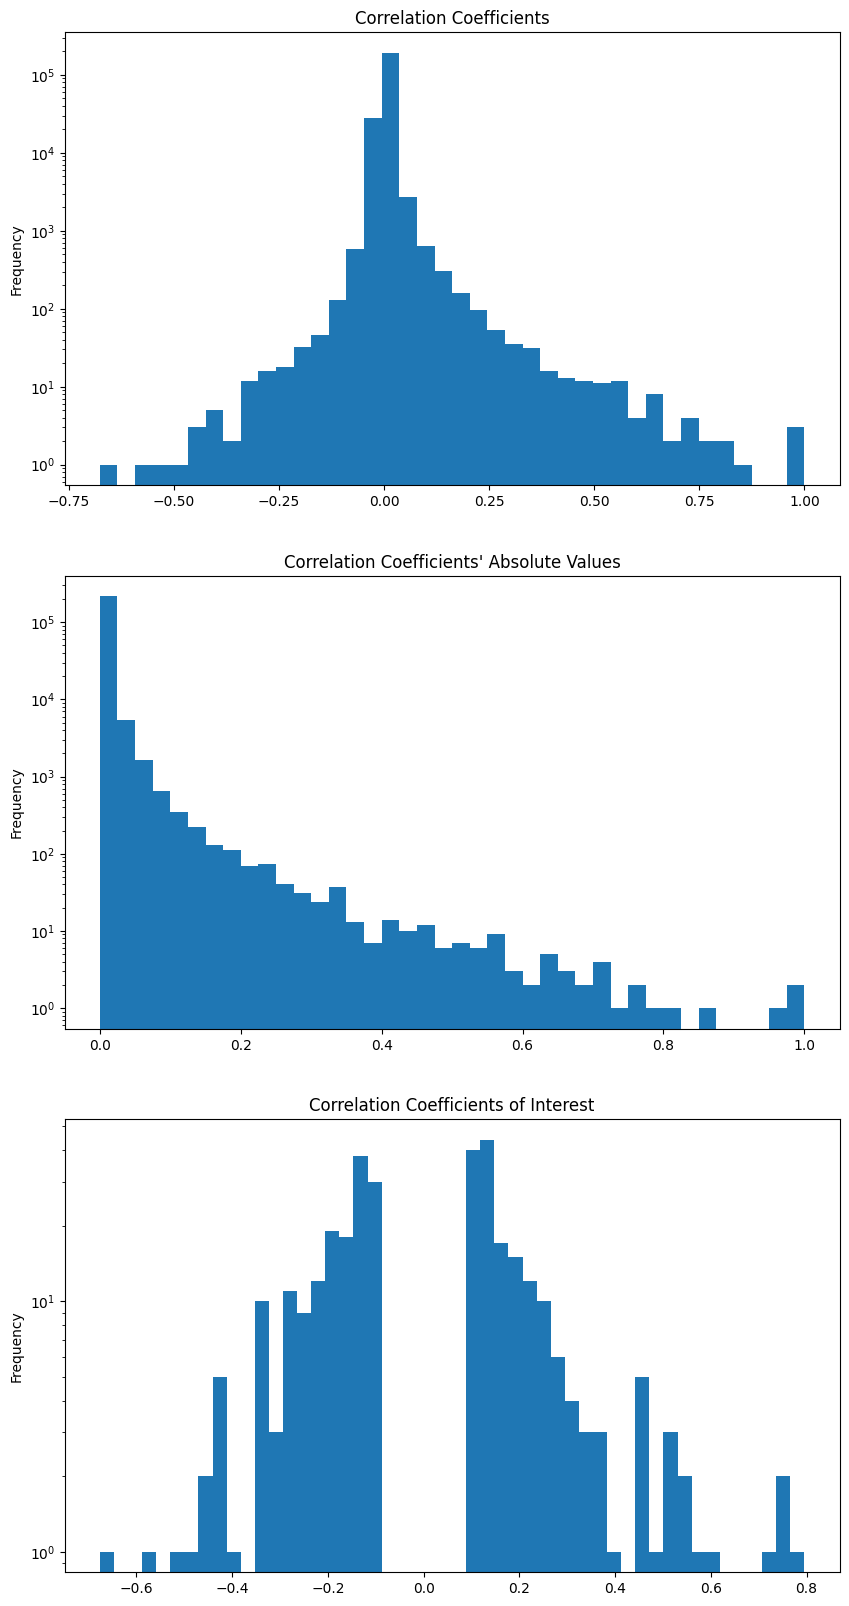

In [120]:
sorted_crime_corrs, crime_corrs_of_interest = do_corr_analysis(crime_corr, 0.1, 1, "pug_agency_name|state_name")

In [121]:
crime_corrs_of_interest

index                                           feature1  \
681    33365                victim_types_Religious Organization   
683     4120                           total_individual_victims   
685    34010                        victim_types_Society/Public   
693   416275                      division_name_Middle Atlantic   
699   426359                                offender_race_White   
723    78698                        location_name_Other/Unknown   
725   429079                   offender_ethnicity_Not Specified   
727     2037                               adult_offender_count   
745     2717                            juvenile_offender_count   
747     3401                                       victim_count   
755   429759                         offender_ethnicity_Unknown   
759   459688                                 multiple_offense_M   
761        6                                 adult_victim_count   
767    40008  offense_name_Destruction/Damage/Vandalism of P...   
783    40111             offense_name_Drug Equipment Violations   
785      631                                 adult_victim_count   
791    18946                              bias_desc_Anti-Jewish   
795    78133                        location_name_Other/Unknown   
799    32619                                 victim_types_Other   
801    57086                 offense_name_Weapon Law Violations   
807   425057                              offender_race_Unknown   
809     2839                            juvenile_offender_count   
817   425056                              offender_race_Unknown   
825    33996                        victim_types_Society/Public   
827     2668                               adult_offender_count   
831   422965            offender_race_Black or African American   
833    31282                            victim_types_Individual   
839    29243                              victim_types_Business   
847       46                                 adult_victim_count   
851    31292                            victim_types_Individual   
885   427773          offender_ethnicity_Not Hispanic or Latino   
889    29967                 victim_types_Financial Institution   
893    32650                                 victim_types_Other   
895      802                              juvenile_victim_count   
899    32598                                 victim_types_Other   
905   425684                              offender_race_Unknown   
913    33956                        victim_types_Society/Public   
927    31294                            victim_types_Individual   
929    29203                              victim_types_Business   
933    31847                            victim_types_Individual   
935     1361                               total_offender_count   
941    18391                              bias_desc_Anti-Jewish   
947    40009  offense_name_Destruction/Damage/Vandalism of P...   
949    39388  offense_name_Destruction/Damage/Vandalism of P...   
959    52341                        offense_name_Simple Assault   
963    33317                victim_types_Religious Organization   
969    33308                victim_types_Religious Organization   
975    52350                        offense_name_Simple Assault   
987   425667                              offender_race_Unknown   
991    78112                        location_name_Other/Unknown   
997   419559                       division_name_South Atlantic   
1003   31279                            victim_types_Individual   
1013  425736                                offender_race_White   
1021  425102                              offender_race_Unknown   
1029  425081                              offender_race_Unknown   
1033  416233                      division_name_Middle Atlantic   
1045   25217                      bias_desc_Anti-Other Religion   
1049   74130   location_name_Highway/Road/Alley/Street/Sidewalk   
1051   39995  offense_name_Destruction/Damage/Vandalis

####Quantitative variable figures

<Axes: title={'center': 'total_offender_count'}, ylabel='Frequency'>

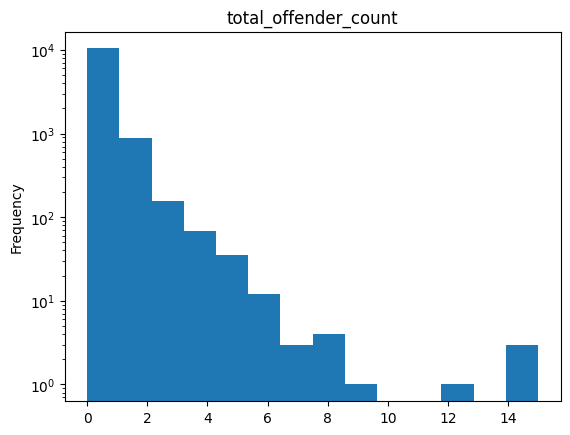

In [122]:
crime_df['total_offender_count'].plot.hist(bins=14, title='total_offender_count', logy=True)

<Axes: title={'center': 'adult_victim_count'}, ylabel='Frequency'>

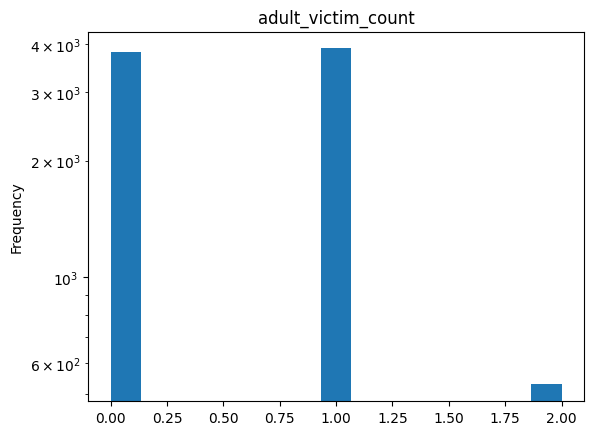

In [123]:
crime_df['adult_victim_count'].plot.hist(bins=15, title='adult_victim_count', logy=True)

<Axes: title={'center': 'juvenile_victim_count'}, ylabel='Frequency'>

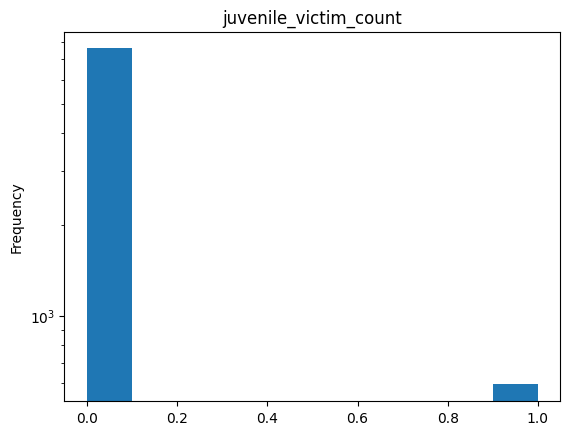

In [124]:
crime_df['juvenile_victim_count'].plot.hist(bins=10, title='juvenile_victim_count', logy=True)

####Categorical variable figures


In [125]:
def plot_column_counts(df, column_name, unique_values, title_phrase, figsize=(20, 5), rotation=90):
    # Create a dictionary of unique values and their counts
    unique_value_counts = get_col_counts(df, unique_values)

    # Sort the dictionary by values in descending order
    sorted_value_counts = dict(sorted(unique_value_counts.items(), key=lambda item: item[1], reverse=True))

    # Create a bar chart of the sorted valuees and their counts
    plt.figure(figsize=figsize)
    sns.barplot(x=list(sorted_value_counts.keys()), y=list(sorted_value_counts.values()), log=True)

    # Set the title and labels
    plt.title("Frequency of " + title_phrase + " in Hate Crimes", fontsize=16)
    plt.xlabel(title_phrase, fontsize=14)
    plt.ylabel("Frequency (Log Scale)", fontsize=14)

    # Rotate the x-axis labels for readability
    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show()


(array([0, 1, 2, 3]),
 [Text(0, 0, 'South'),
  Text(1, 0, 'West'),
  Text(2, 0, 'Midwest'),
  Text(3, 0, 'Northeast')])

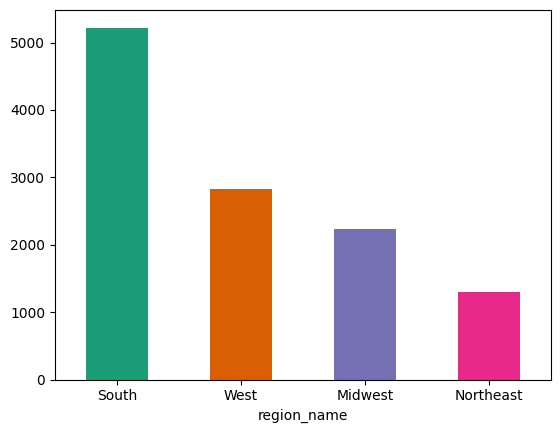

In [126]:
crime_df.groupby('region_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

<Axes: ylabel='offender_race'>

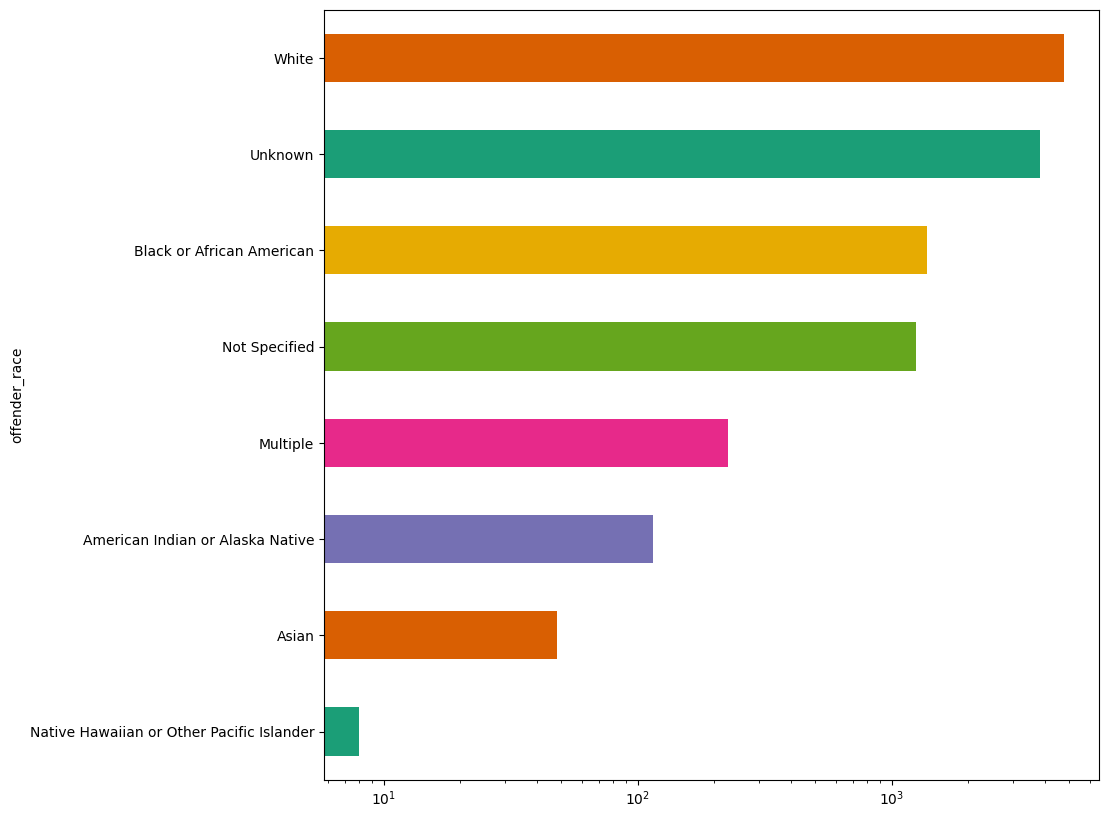

In [127]:
crime_df.groupby('offender_race').size().sort_values(ascending=True).plot.barh(color=sns.palettes.mpl_palette('Dark2'), figsize=(10,10), logx=True)

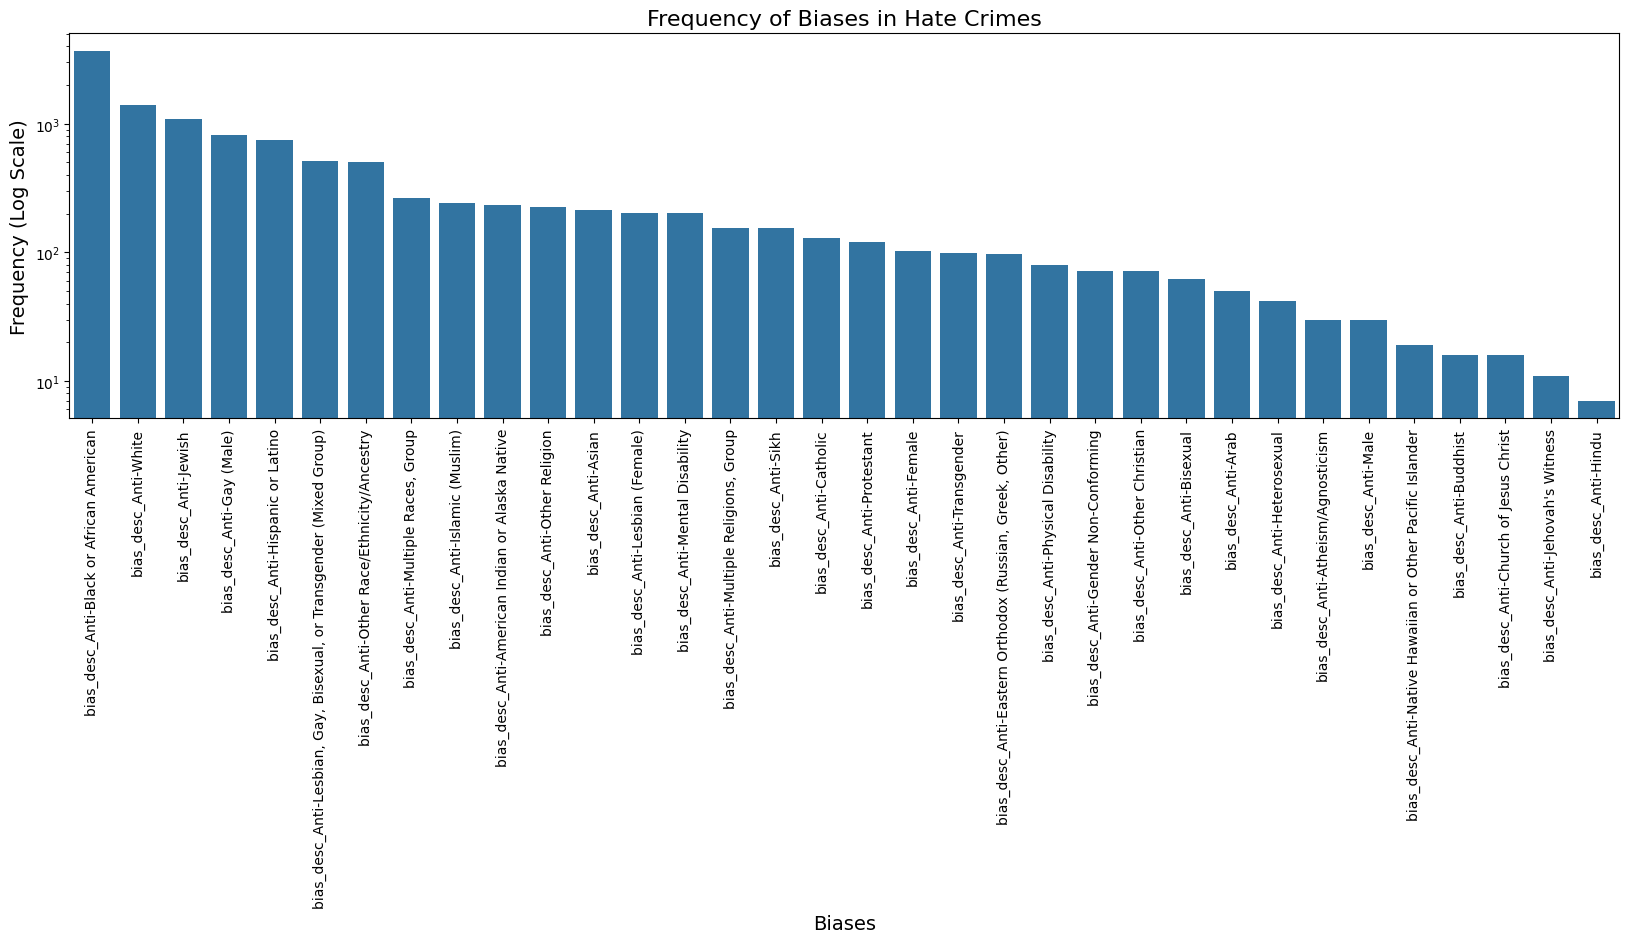

In [128]:
plot_column_counts(crime_df, "bias_desc", bias_cols, "Biases")

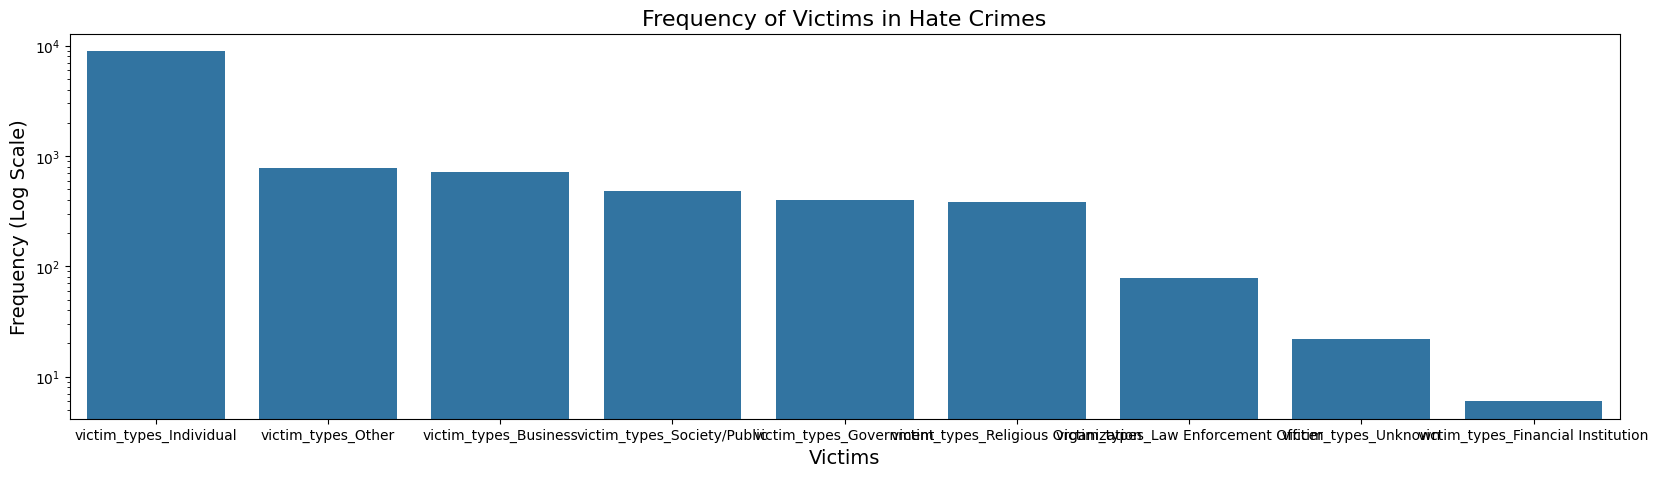

In [129]:
figsize=(20, 5)
plot_column_counts(crime_df, "victim_types", victim_cols, "Victims", figsize, 0)

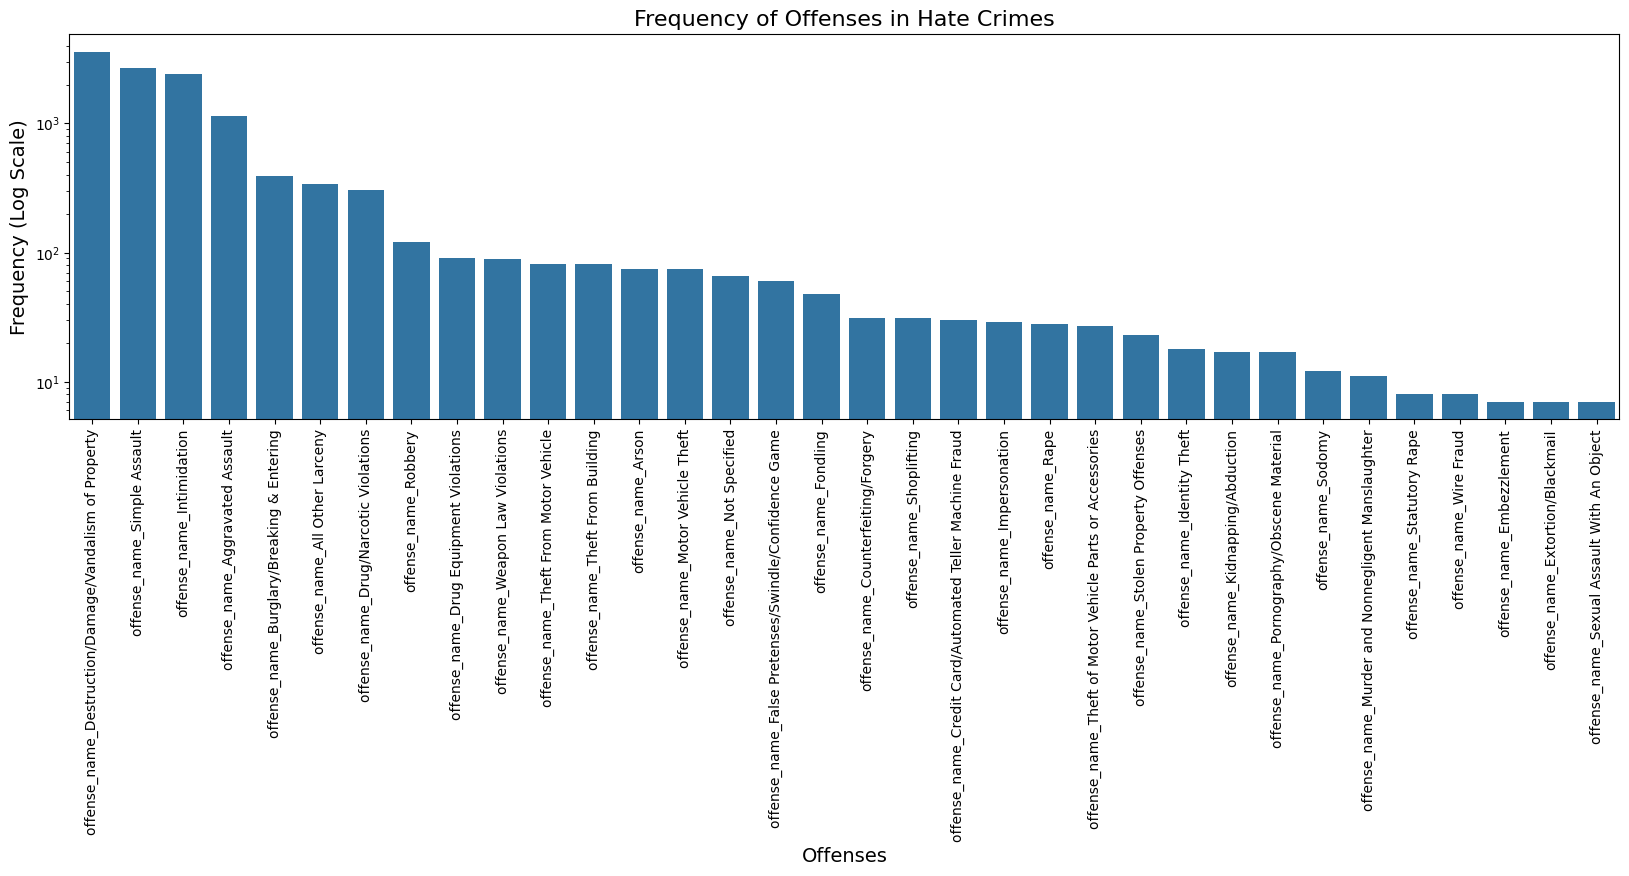

In [130]:
plot_column_counts(crime_df, "offense_name", offense_cols, "Offenses")

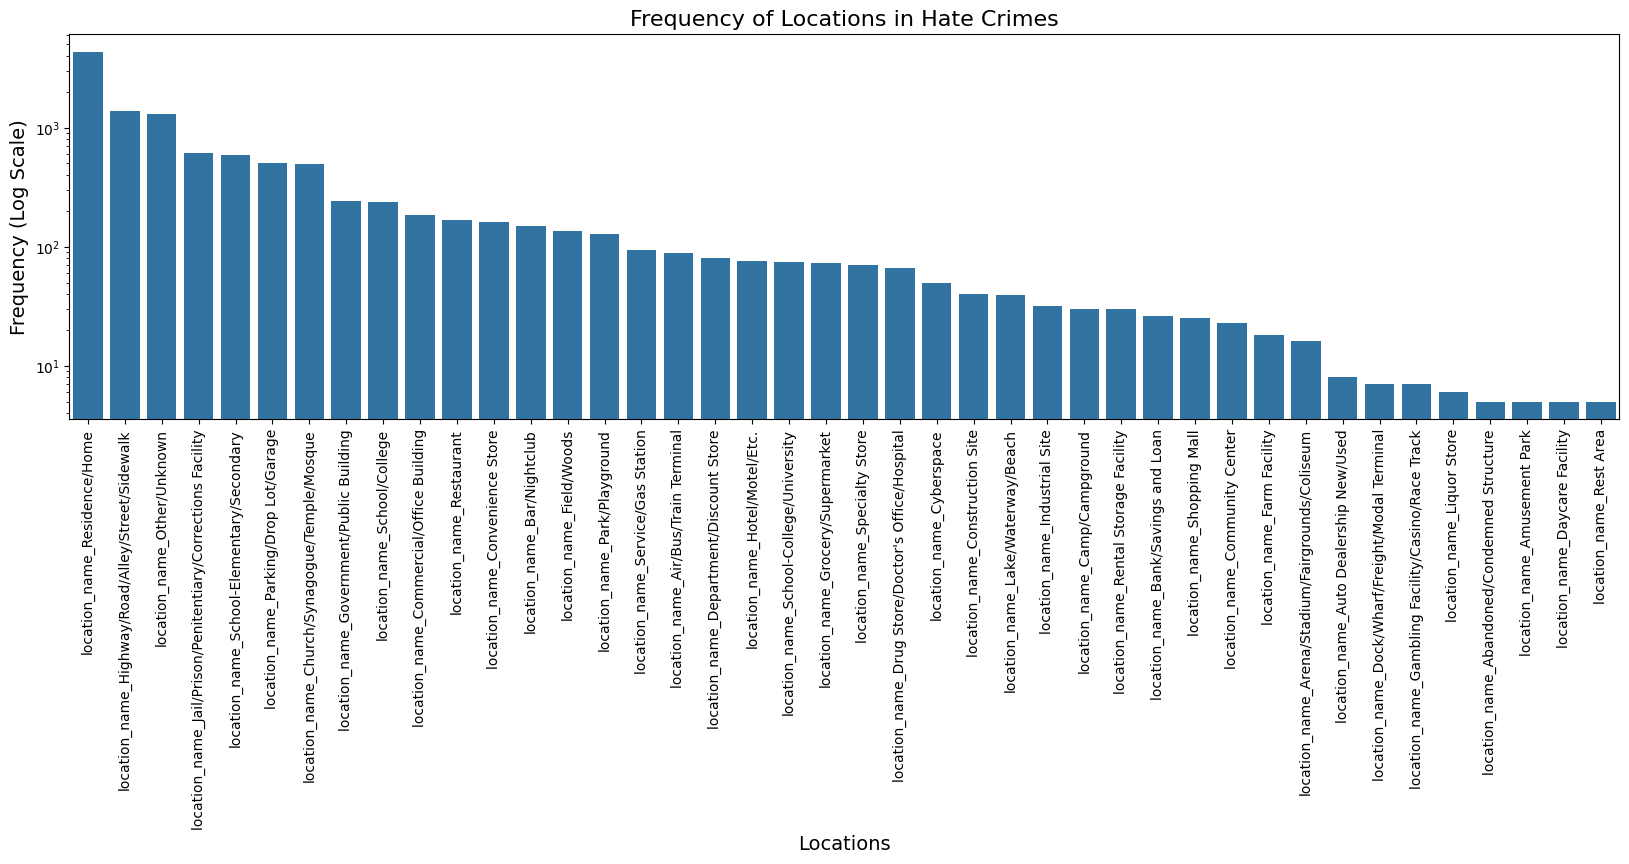

In [131]:
plot_column_counts(crime_df, "location_names", location_cols, "Locations")

####Geographic heat maps

In [132]:
ignore_list = ["Not Specified", "Unknown", "Multiple"]

Text(70.7222222222222, 0.5, 'Offender Race')

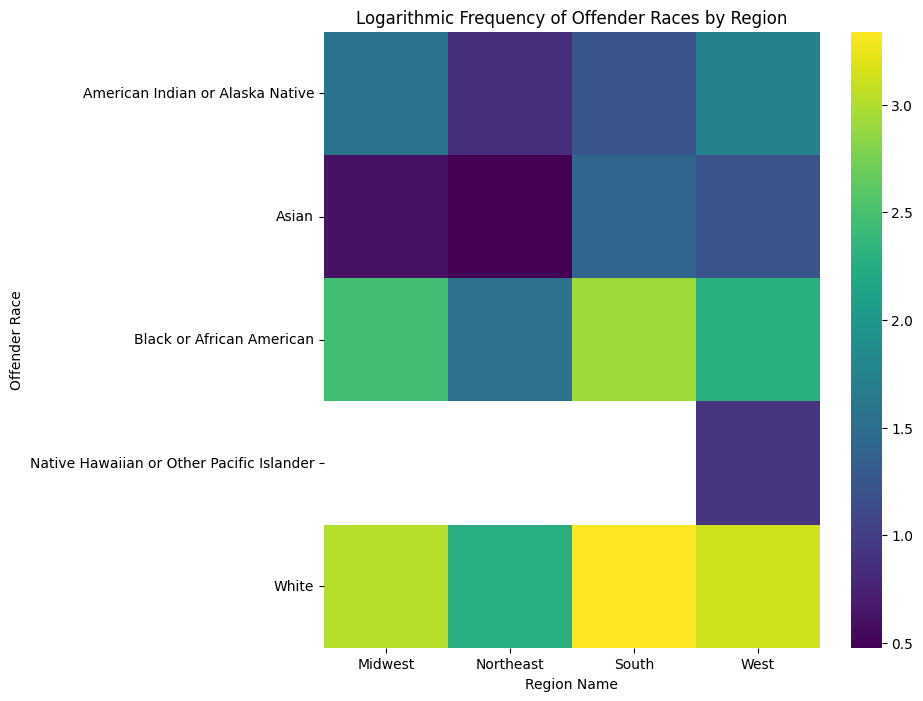

In [133]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})

# Drop less relevant columns for easier comparison with victim race heatmap
for item in ignore_list:
  df_2dhist.drop(item, inplace=True)

# Apply logarithmic transformation to the counts
df_2dhist_log = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

sns.heatmap(df_2dhist_log, cmap='viridis')
plt.title("Logarithmic Frequency of Offender Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Offender Race")

In [134]:
# Get some victim races to start with
unique_offender_races = crime_df['offender_race'].unique().tolist()

# Drop categories absent from victim data
for item in ignore_list:
  unique_offender_races.remove(item)

unique_victim_races = ["bias_desc_Anti-" + str(race) for race in unique_offender_races]

print(unique_victim_races)

['bias_desc_Anti-White', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Native Hawaiian or Other Pacific Islander']


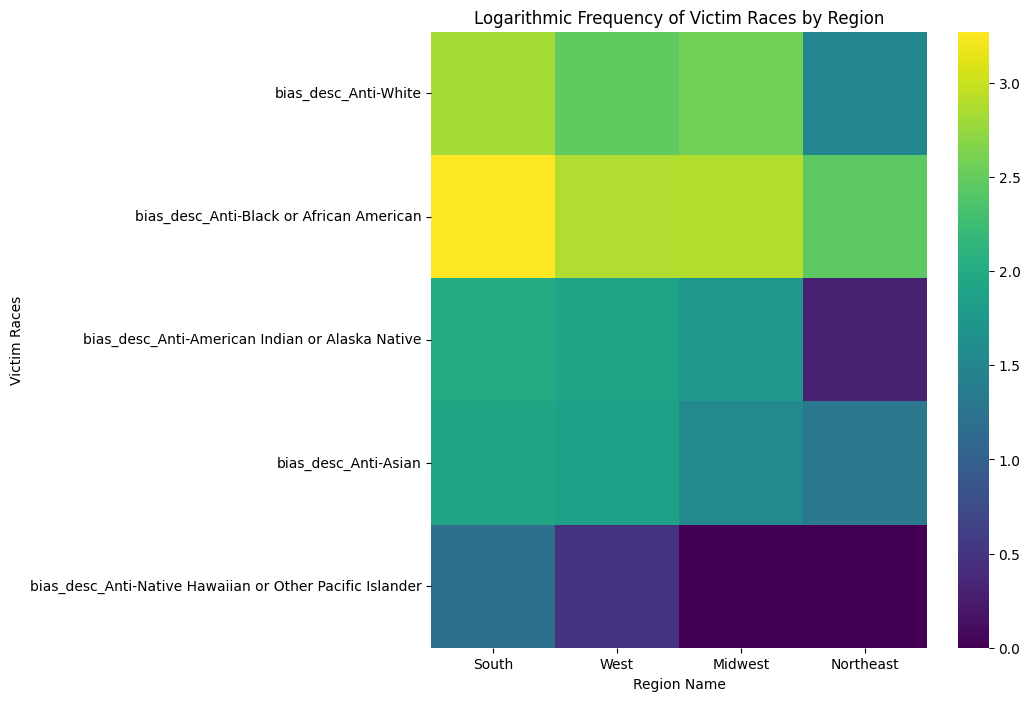

In [135]:
plt.subplots(figsize=(8, 8))

# Initialize an empty DataFrame with the correct index and columns
df_2dhist = pd.DataFrame(index=unique_victim_races, columns=crime_df['region_name'].unique())

# Iterate over each region and calculate the value counts for each victim race
for region in df_2dhist.columns:
    region_data = crime_df[crime_df['region_name'] == region]

    for victim_race in unique_victim_races:
        count = 0
        # Sum of occurrences of victim_race in the region
        if victim_race in region_data.columns:
          count = region_data[victim_race].sum()
        # Update the DataFrame cell with the count
        df_2dhist.loc[victim_race, region] = count

# Convert DataFrame entries to numeric type and drop nan values
df_2dhist = df_2dhist.apply(pd.to_numeric)

# Apply logarithmic transformation to the counts
df_2dhist = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

# Create the heatmap with logarithmic scale
sns.heatmap(df_2dhist, cmap='viridis')

# Give the plot a title and axis labels
plt.title("Logarithmic Frequency of Victim Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Victim Races")
plt.yticks(rotation=0)

plt.show()

###County Demographics Dataset

In [136]:
county_demo_df.head()

Geography     Geographic Area Name  Total population  \
0  0500000US01003  Baldwin County, Alabama            183195   
1  0500000US01015  Calhoun County, Alabama            118510   
2  0500000US01043  Cullman County, Alabama             80459   
3  0500000US01049   DeKalb County, Alabama             71151   
4  0500000US01051   Elmore County, Alabama             79549   

  Percent!!Total population RACE!!Total population  \
0                    183195                 183195   
1                    118510                 118510   
2                     80459                  80459   
3                     71151                  71151   
4                     79549                  79549   

   Percent!!RACE!!Total population  \
0                         183195.0   
1                         118510.0   
2                          80459.0   
3                          71151.0   
4                          79549.0   

  RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                             183195                                  
1                                             118510                                  
2                                              80459                                  
3                                              71151                                  
4                                              79549                                  

   Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                           183195.0                                            
1                                           118510.0                                            
2                                            80459.0                                            
3                                            71151.0                                            
4                                            79549.0                                            

  RACE!!White  Percent!!RACE!!White RACE!!Black or African American  \
0      162119                  88.5                           18068   
1       89517                  75.5                           25510   
2       77999                  96.9                            1596   
3       66804                  93.9                            2158   
4       61869                  77.8                           16499   

   Percent!!RACE!!Black or African American  \
0                                       9.9   
1                                      21.5   
2                                       2.0   
3                                       3.0   
4                                      20.7   

  RACE!!American Indian and Alaska Native  \
0                                    2360   
1                                     972   
2                                     863   
3                                    2182   
4                                     858   

   Percent!!RACE!!American Indian and Alaska Native RACE!!Asian  \
0                                               1.3        1740   
1                                               0.8        1086   
2                                               1.1           N   
3                                               3.1           N   
4                                               1.1         817   

   Percent!!RACE!!Asian RACE!!Native Hawaiian and Other Pacific Islander  \
0                   0.9                                                N   
1                   0.9                                                N   
2                   0.0                                                N   
3                   0.0                                                N   
4                   1.0                                                N   

   Percent!!RACE!!Native Hawaiian and Other Pacific Islander  \
0                                                0.0      

####Correlation matrix

In [137]:
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)
county_numerical_cols = [col for col in county_numerical_cols if "transformed_" in col]

In [138]:
# Create a correlation matrix
county_corr = county_demo_df[county_numerical_cols].corr()

In [139]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(county_corr, annot=True)

# # Show the plot
# plt.show()

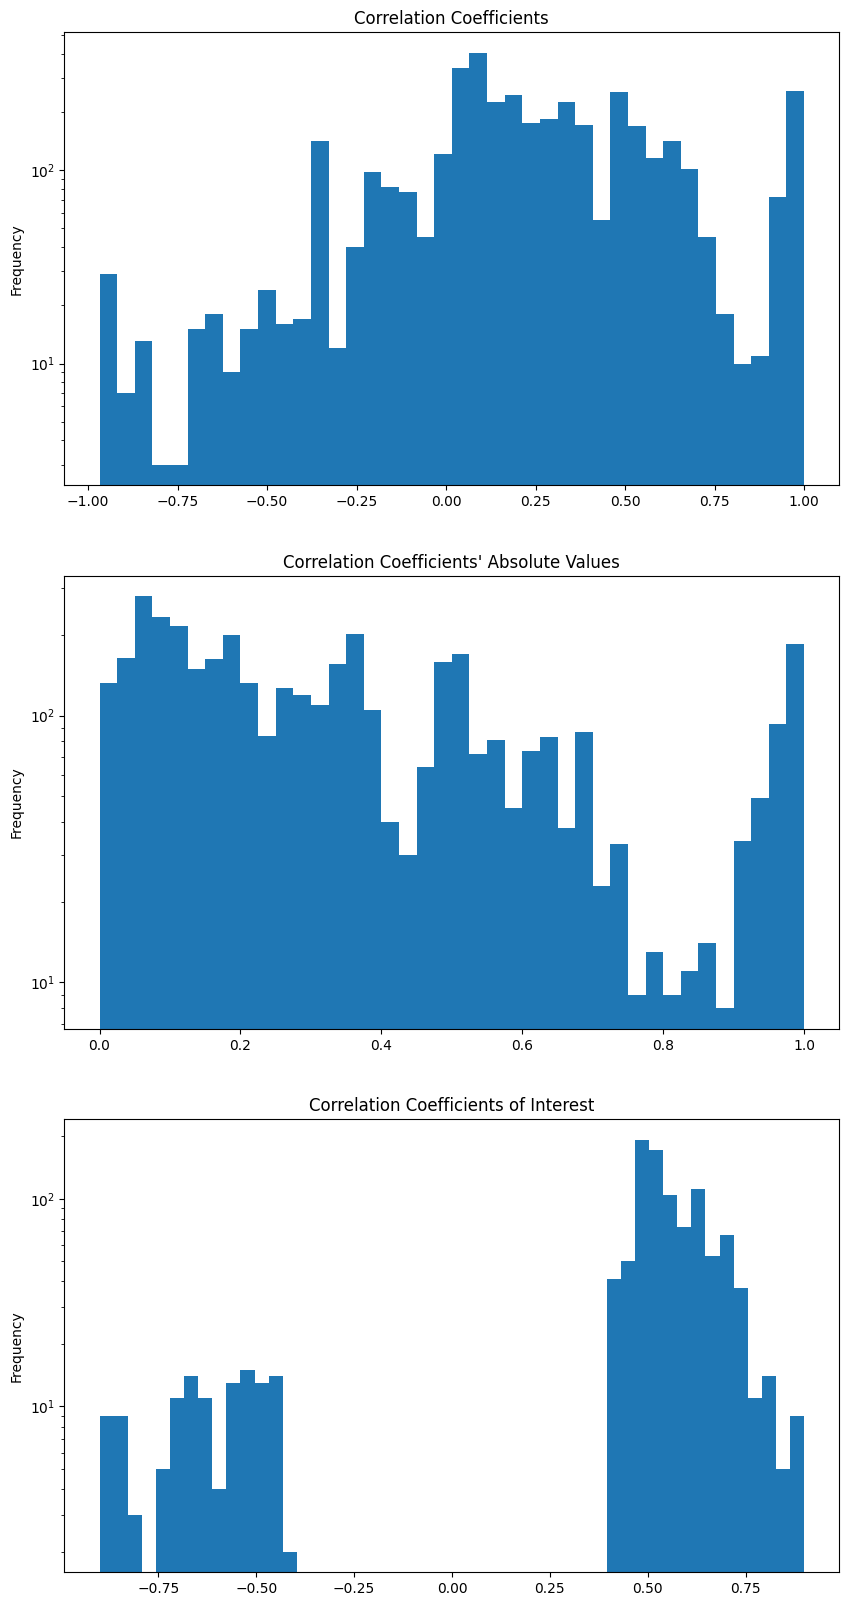

In [140]:
sorted_county_corrs, county_corrs_of_interest = do_corr_analysis(county_corr, 0.4, 0.9, "pug_agency_name|state_name")

In [141]:
county_corrs_of_interest.reset_index(inplace=True)

In [142]:
county_corrs_of_interest

level_0  index                                           feature1  \
0         814   1095                transformed_Percent!!RACE!!One race   
1         816   5983  transformed_Percent!!RACE!!One race!!Some othe...   
2         818    376  transformed_Percent!!RACE!!Black or African Am...   
3         820   1112                transformed_Percent!!RACE!!One race   
4         822    229  transformed_Percent!!RACE!!Race alone or in co...   
5         824   1293  transformed_Percent!!HISPANIC OR LATINO AND RA...   
6         826   1923  transformed_Percent!!HISPANIC OR LATINO AND RA...   
7         828   1286  transformed_Percent!!HISPANIC OR LATINO AND RA...   
8         830   1115                transformed_Percent!!RACE!!One race   
9         832    293                   transformed_Percent!!RACE!!White   
10        834   1749  transformed_Percent!!HISPANIC OR LATINO AND RA...   
11        836   1914  transformed_Percent!!HISPANIC OR LATINO AND RA...   
12        838   1111                transformed_Percent!!RACE!!One race   
13        840   2096  transformed_Percent!!HISPANIC OR LATINO AND RA...   
14        842   1824  transformed_Percent!!HISPANIC OR LATINO AND RA...   
15        844   1915  transformed_Percent!!HISPANIC OR LATINO AND RA...   
16        846   2097  transformed_Percent!!HISPANIC OR LATINO AND RA...   
17        848   1565  transformed_Percent!!HISPANIC OR LATINO AND RA...   
18        850    467  transformed_Percent!!RACE!!American Indian and...   
19        852   2107  transformed_Percent!!HISPANIC OR LATINO AND RA...   
20        854   1098                transformed_Percent!!RACE!!One race   
21        856   1473  transformed_Percent!!HISPANIC OR LATINO AND RA...   
22        858   1295  transformed_Percent!!HISPANIC OR LATINO AND RA...   
23        860   1100                transformed_Percent!!RACE!!One race   
24        862   1382  transformed_Percent!!HISPANIC OR LATINO AND RA...   
25        864   1930  transformed_Percent!!HISPANIC OR LATINO AND RA...   
26        866    475  transformed_Percent!!RACE!!American Indian and...   
27        868    476  transformed_Percent!!RACE!!American Indian and...   
28        870   1826  transformed_Percent!!HISPANIC OR LATINO AND RA...   
29        872    478  transformed_Percent!!RACE!!American Indian and...   
30        874    567                   transformed_Percent!!RACE!!Asian   
31        876    569                   transformed_Percent!!RACE!!Asian   
32        878   5150  transformed_Percent!!RACE!!One race!!Asian!!Ja...   
33        880   5061  transformed_Percent!!RACE!!One race!!Asian!!Fi...   
34        882   5425  transformed_Percent!!RACE!!One race!!Asian!!Ot...   
35        884   5153  transformed_Percent!!RACE!!One race!!Asian!!Ja...   
36        886   2112  transformed_Percent!!HISPANIC OR LATINO AND RA...   
37        888   1294  transformed_Percent!!HISPANIC OR LATINO AND RA...   
38        890   1828  transformed_Percent!!HISPANIC OR LATINO AND RA...   
39        892   1919  transformed_Percent!!HISPANIC OR LATINO AND RA...   
40        894    751         transformed_Percent!!RACE!!Some other race   
41        896   4879  transformed_Percent!!RACE!!One race!!Asian!!As...   
42        898   1105                transformed_Percent!!RACE!!One race   
43        900   7818  transformed_Percent!!RACE!!Two or More Races!!...   
44        902   2119  transformed_Percent!!HISPANIC OR LATINO AND RA...   
45        904   2121  transformed_Percent!!HISPANIC OR LATINO AND RA...   
46        906   7815  transformed_Percent!!RACE!!Two or More Races!!...   
47        908   2386  transformed_Percent!!HISPANIC OR LATINO AND RA...   
48        910   2568  transformed_Percent!!HISPANIC OR LATINO AND RA...   
49        912   2569  transformed_Percent!!HISPANIC OR LATINO AND RA...   
50        914   1937  transformed_Percent!!HISPANIC OR LATINO AND RA...   
51        916   5334  transformed_Percent!!RACE!!One race!!Asian!!Vi...   
52        918   5794  transform

####Scatter Plots

In [143]:
# create a scatter plot for every feature pair in case there's one of interest
for i in range(len(county_corrs_of_interest)):
    row = county_corrs_of_interest.iloc[i]
    # county_demo_df.plot.scatter(x=row["feature1"], y=row["feature2"])

####Other figures

<Axes: xlabel='Under 5 years', ylabel='85 years and over'>

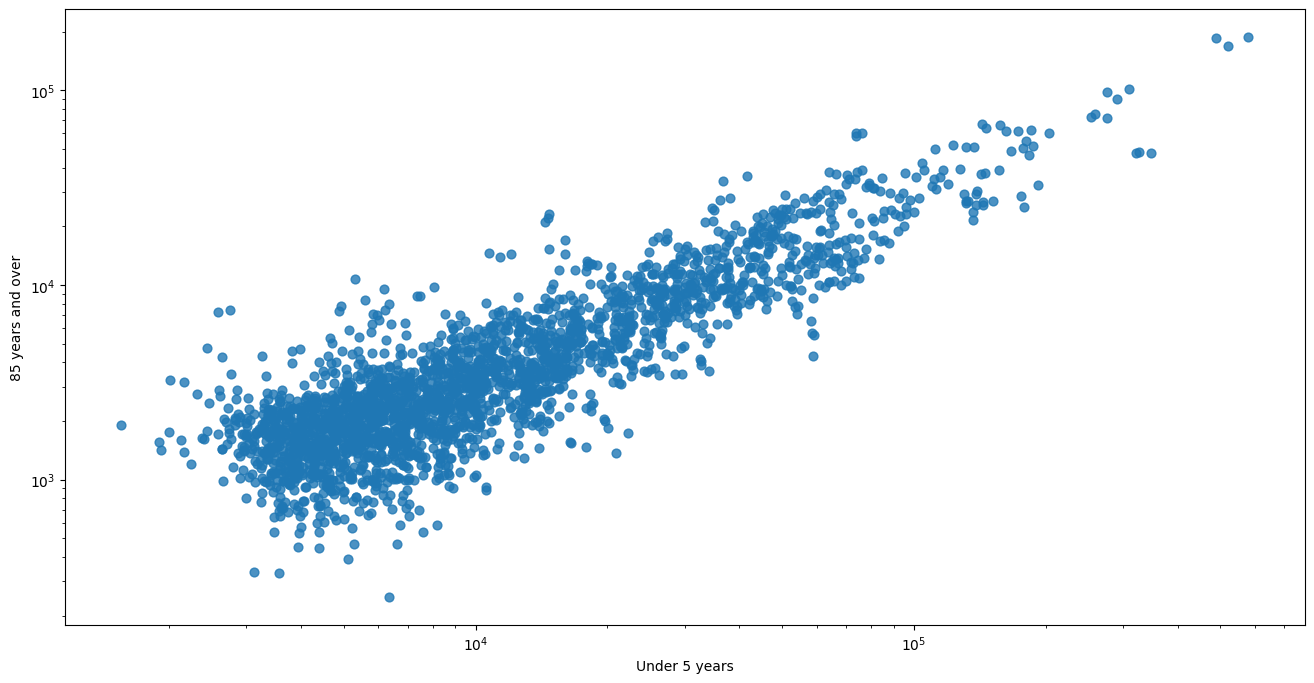

In [144]:
county_demo_df.plot.scatter(x='Under 5 years', y='85 years and over', logx=True, logy=True, s=40, alpha=.8, figsize=(16,8))

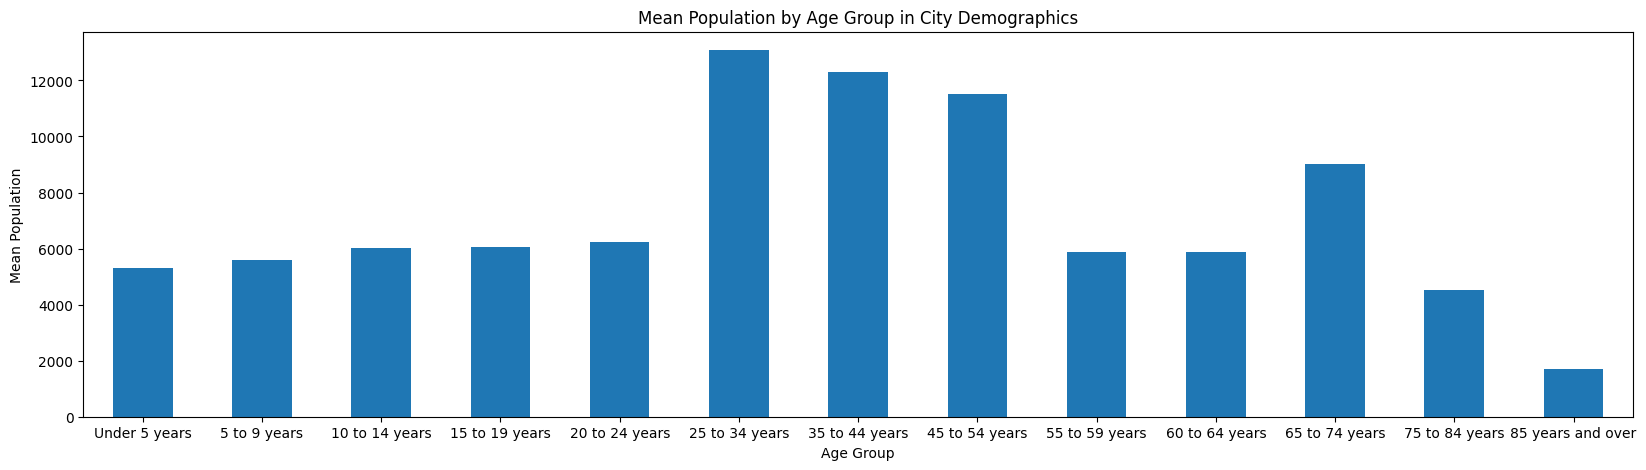

In [145]:
county_demo_df[age_groups].mean().plot.bar(figsize=(20,5))
plt.xlabel('Age Group')
plt.ylabel('Mean Population')
plt.title('Mean Population by Age Group in City Demographics')
plt.xticks(rotation=0)
plt.show()

##Merged Datasets

###Primary Merged Dataset

In [146]:
merged_df.head()

incident_id  data_year region_name  adult_victim_count  \
0       143590       2010       South                 NaN   
1       143591       2010       South                 NaN   
2       143592       2010       South                 NaN   
3       143593       2010       South                 NaN   
4       143594       2010       South                 NaN   

   juvenile_victim_count  total_offender_count  adult_offender_count  \
0                    NaN                     1                   NaN   
1                    NaN                     1                   NaN   
2                    NaN                     1                   NaN   
3                    NaN                     0                   NaN   
4                    NaN                     1                   NaN   

   juvenile_offender_count  victim_count    offense_name  \
0                      NaN             1    Intimidation   
1                      NaN             1  Simple Assault   
2                      NaN             1  Simple Assault   
3                      NaN             1    Intimidation   
4                      NaN             1  Simple Assault   

   total_individual_victims  incident_month  incident_day  \
0                       1.0               9             1   
1                       1.0               6            16   
2                       1.0               6            16   
3                       1.0               4             5   
4                       1.0               4             2   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1                                                0                    0   
2                                                0                    0   
3                                                0                    0   
4                                                0                    0   

   bias_desc_Anti-Asian  bias_desc_Anti-Atheism/Agnosticism  \
0                     0                                   0   
1                     0                                   0   
2                     0                                   0   
3                     0                                   0   
4                     0                                   0   

   bias_desc_Anti-Bisexual  bias_desc_Anti-Black or African American  \
0                        0                                         1   
1                        0                                         0   
2                        0                                         1   
3                        0                                         1   
4                        0                                         1   

   bias_desc_Anti-Buddhist  bias_desc_Anti-Catholic  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   

   bias_desc_Anti-Church of Jesus Christ  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   bias_desc_Anti-Female  bias_desc_Anti-Gay (Male)  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      

####Correlation Matrix Analysis

In [147]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df\
                          .select_dtypes(include=['int64', 'float64', np.number])\
                          .drop(labels=["incident_id"], axis=1)
# Select only the numerical columns
numerical_cols = [col for col in categorical_to_int_df.columns if "transformed_" in col]
# numerical_cols

In [148]:
# Create a correlation matrix
merged_corr = merged_df[numerical_cols].corr()

In [149]:
merged_corr_sorted = get_sorted_corrs(merged_corr)
merged_corr_sorted.head()

index                                           feature1  \
28    1235        transformed_Percent!!RACE!!Total population   
38    1142                       transformed_Total population   
49    2051  transformed_Percent!!HISPANIC OR LATINO AND RA...   
107   5181                         transformed_45 to 54 years   
109   4531                           transformed_5 to 9 years   

                                              feature2      corr  abs_corr  
28                        transformed_Total population  1.000000  1.000000  
38   transformed_Percent!!HISPANIC OR LATINO AND RA...  1.000000  1.000000  
49                        transformed_Total population  1.000000  1.000000  
107  transformed_Percent!!Race alone or in combinat...  0.999951  0.999951  
109                          transformed_Under 5 years  0.999949  0.999949

In [150]:
# remove coefficients that represent variables' correlations with themselves
#   and remove feature correlations with other features from the same set (which were reviewed in the individual dataset explorations above)
county_cols = list(county_numerical_cols)
crime_cols = list(crime_numerical_cols)

merged_corr_sorted = merged_corr_sorted[~(
    ((merged_corr_sorted["feature1"].isin(county_cols))
      & (merged_corr_sorted["feature2"].isin(county_cols)))
    | ((merged_corr_sorted["feature1"].isin(crime_cols))
      & (merged_corr_sorted["feature2"].isin(crime_cols)))
)]

In [151]:
merged_corr_sorted.head()

index                    feature1  \
193     124     transformed_data_year_x   
895      22     transformed_incident_id   
899       1     transformed_incident_id   
1151   5508  transformed_75 to 84 years   
1153    199     transformed_data_year_x   

                                               feature2      corr  abs_corr  
193                             transformed_data_year_y  0.999304  0.999304  
895                             transformed_data_year_y  0.892188  0.892188  
899                             transformed_data_year_x  0.884034  0.884034  
1151                            transformed_incident_id  0.792600  0.792600  
1153  transformed_Percent!!Race alone or in combinat...  0.792372  0.792372

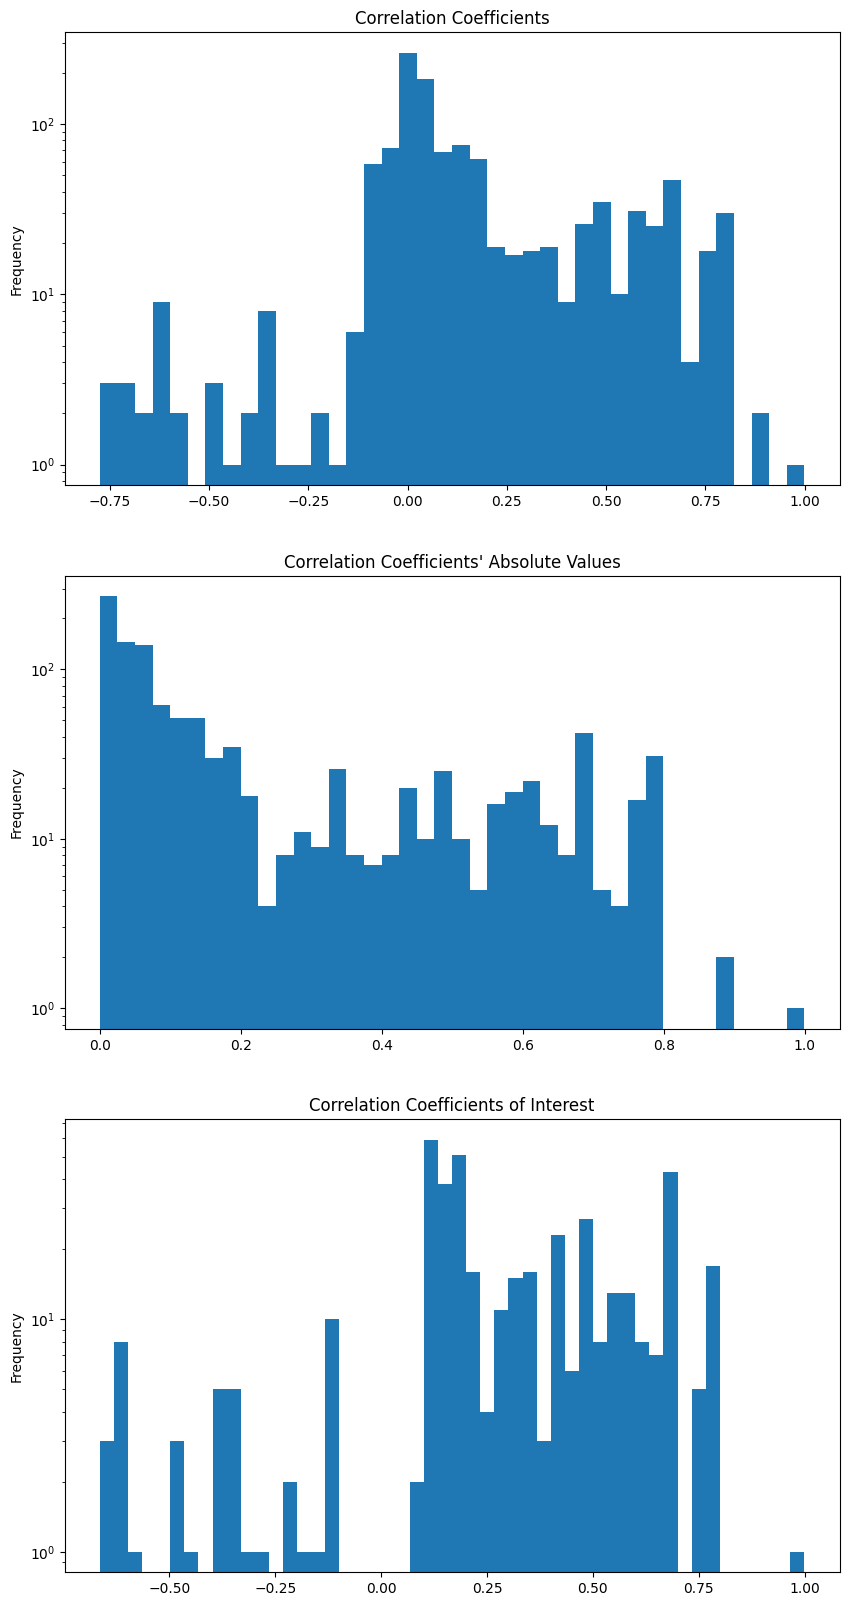

In [152]:
# drop half the entries, which are essentially duplicates,
#   as well as any np.nan entries and entries with low correlation coefficients or exceedingly high correlation coefficients,
#   which have already been considered previously or present trivial correlation information
#   (ie the number of individuals under 5 years of age is directly correlated with the total population)
merged_corr_sorted, merged_corrs_of_interest = do_corr_analysis(merged_corr, 0.1, 1, "state_name|division_name|pug_agency_name|index|incident_id", merged_corr_sorted)

In [153]:
merged_corrs_of_interest

index                                           feature1  \
193     124                            transformed_data_year_x   
1153    199                            transformed_data_year_x   
1171    191                            transformed_data_year_x   
1175    192                            transformed_data_year_x   
1223  10303  transformed_Percent!!HISPANIC OR LATINO AND RA...   
1225  10099  transformed_Percent!!HISPANIC OR LATINO AND RA...   
1241    202                            transformed_data_year_x   
1265   9997  transformed_Percent!!HISPANIC OR LATINO AND RA...   
1285    194                            transformed_data_year_x   
1287    193                            transformed_data_year_x   
1289   9589  transformed_Percent!!RACE!!Two or More Races!!...   
1293   9916  transformed_Percent!!Race alone or in combinat...   
1295   2333                            transformed_data_year_y   
1297   9202       transformed_Percent!!RACE!!Two or More Races   
1301   9487  transformed_Percent!!RACE!!Two or More Races!!...   
1305   2345                            transformed_data_year_y   
1307  10120  transformed_Percent!!HISPANIC OR LATINO AND RA...   
1313  10222  transformed_Percent!!HISPANIC OR LATINO AND RA...   
1349   2342                            transformed_data_year_y   
1357   9406  transformed_Percent!!RACE!!Two or More Races!!...   
1359   2335                            transformed_data_year_y   
1361   2338                            transformed_data_year_y   
1371   2337                            transformed_data_year_y   
1701   8569  transformed_Percent!!Race alone or in combinat...   
1707   8590  transformed_Percent!!Race alone or in combinat...   
1713   5509                         transformed_75 to 84 years   
1717   8467  transformed_Percent!!Race alone or in combinat...   
1719   5530                         transformed_75 to 84 years   
1721   8488  transformed_Percent!!Race alone or in combinat...   
1727   9793  transformed_Percent!!RACE!!Two or More Races!!...   
1733   5815  transformed_Percent!!RACE!!One race!!Black or ...   
1735    155                            transformed_data_year_x   
1737   5305                         transformed_60 to 64 years   
1743   5836  transformed_Percent!!RACE!!One race!!Black or ...   
1747   2297                            transformed_data_year_y   
1749   2296                            transformed_data_year_y   
1751   6427         transformed_Percent!!RACE!!One race!!Asian   
1755    157                            transformed_data_year_x   
1757   6448         transformed_Percent!!RACE!!One race!!Asian   
1759    149                            transformed_data_year_x   
1763    187                            transformed_data_year_x   
1765   5632                      transformed_85 years and over   
1767   2291                            transformed_data_year_y   
1769   4693                         transformed_15 to 19 years   
1771   8263  transformed_Percent!!Race alone or in combinat...   
1773   8692  transformed_Percent!!Race alone or in combinat...   
1775   5101                         transformed_45 to 54 years   
1777   4489                           transformed_5 to 9 years   
1781   2290                            transformed_data_year_y   
1783   4897                         transformed_25 to 34 years   
1785   8284  transformed_Percent!!Race alone or in combinat...   
1787    151                            transformed_data_year_x   
1789    147                            transformed_data_year_x   
1793   2294                            transformed_data_year_y   
1795   2288                            transformed_data_year_y   
1805   4918                         transformed_25 to 34 years   
1807   5020                         transformed_35 to 44 years   
1809   4387                          transformed_Under 5 years   
1811   8365  transformed_Percent!!Race alone or in combinat...   
1813   4612                         transforme

####Other Figures

KeyError: 'transformed_Percent!!45 to 54 years'

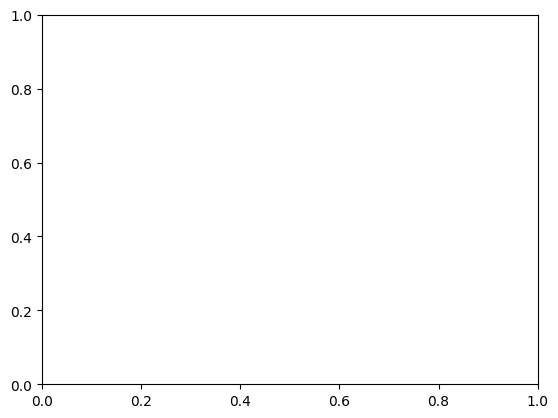

In [154]:
merged_df.plot.scatter(x="transformed_Percent!!RACE!!One race!!White", y="transformed_Percent!!45 to 54 years")

###County Feature Prediction Dataset

In [155]:
county_hate_rates_df["transformed_data_year"].unique()  #.head()

array([-5.19933758, -1.1062631 , -0.75763137, -0.48259028, -0.23987179,
       -0.01041364,  0.21905165,  0.46160547,  0.73733912,  1.08651915,
        5.19933758])

In [156]:
county_hate_rates_df.head()

hate_crime_count  hate_crime_count  transformed_Total population  \
0                10                10                     -0.458559   
1                10                10                     -0.463130   
2                10                10                     -0.480898   
3                10                10                     -0.485517   
4                10                10                     -0.489220   

   transformed_Percent!!RACE!!Total population  \
0                                    -0.458559   
1                                    -0.463130   
2                                    -0.480898   
3                                    -0.485517   
4                                    -0.489220   

   transformed_Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  \
0                                           0.030834                                                        
1                                           0.027681                                                        
2                                           0.014662                                                        
3                                           0.013017                                                        
4                                           0.010551                                                        

   transformed_Percent!!RACE!!White  \
0                          2.153657   
1                          2.121367   
2                          2.217835   
3                         -5.199338   
4                         -5.199338   

   transformed_Percent!!RACE!!Black or African American  \
0                                           0.794856      
1                                           0.844710      
2                                           0.844710      
3                                          -5.199338      
4                                          -5.199338      

   transformed_Percent!!RACE!!American Indian and Alaska Native  \
0                                           0.671139              
1                                          -5.199338              
2                                           0.753803              
3                                          -5.199338              
4                                          -5.199338              

   transformed_Percent!!RACE!!Asian  \
0                          0.716637   
1                          0.679573   
2                         -5.199338   
3                         -5.199338   
4                         -5.199338   

   transformed_Percent!!RACE!!Native Hawaiian and Other Pacific Islander  \
0                                          -5.199338                       
1                                          -5.199338                       
2                                          -5.199338                       
3                                          -5.199338                       
4                                          -5.199338                       

   transformed_Percent!!RACE!!Some other race  \
0                                    0.803530   
1                                    0.712039   
2                                    0.756354   
3                                   -5.199338   
4                                   -5.199338   

   transformed_Percent!!HISPANIC OR LATINO AND RACE!!Total population  \
0                                          -0.458559                    
1                                          -0.463130                    
2                                          -0.480898                    
3                                          -0.485517                    
4                                          -0.489220                    

   transformed_Percent!!Total housing units  transformed_data_year  \
0                                 -5.199338              -5.199338   
1                                 -5.199338              -1.1

####Correlation Analysis

In [157]:
hate_rate_corr = county_hate_rates_df[hate_rate_numerical_cols].corr()

In [158]:
hate_rate_corr.head()

hate_crime_count  hate_crime_count  \
hate_crime_count                      1.000000          1.000000   
hate_crime_count                      1.000000          1.000000   
hate_crime_count                      1.000000          1.000000   
hate_crime_count                      1.000000          1.000000   
transformed_Total population          0.197917          0.197917   

                              hate_crime_count  hate_crime_count  \
hate_crime_count                      1.000000          1.000000   
hate_crime_count                      1.000000          1.000000   
hate_crime_count                      1.000000          1.000000   
hate_crime_count                      1.000000          1.000000   
transformed_Total population          0.197917          0.197917   

                              transformed_Total population  \
hate_crime_count                                  0.197917   
hate_crime_count                                  0.197917   
hate_crime_count                                  0.197917   
hate_crime_count                                  0.197917   
transformed_Total population                      1.000000   

                              transformed_Percent!!RACE!!Total population  \
hate_crime_count                                                 0.197917   
hate_crime_count                                                 0.197917   
hate_crime_count                                                 0.197917   
hate_crime_count                                                 0.197917   
transformed_Total population                                     1.000000   

                              transformed_Percent!!RACE!!Race alone or in combination with one or more other races!!Total population  \
hate_crime_count                                                       0.046145                                                        
hate_crime_count                                                       0.046145                                                        
hate_crime_count                                                       0.046145                                                        
hate_crime_count                                                       0.046145                                                        
transformed_Total population                                           0.175690                                                        

                              transformed_Percent!!RACE!!White  \
hate_crime_count                                     -0.003574   
hate_crime_count                                     -0.003574   
hate_crime_count                                     -0.003574   
hate_crime_count                                     -0.003574   
transformed_Total population                         -0.038957   

                              transformed_Percent!!RACE!!Black or African American  \
hate_crime_count                                                       0.004627      
hate_crime_count                                                       0.004627      
hate_crime_count                                                       0.004627      
hate_crime_count                                                       0.004627      
transformed_Total population                                          -0.001484      

                              transformed_Percent!!RACE!!American Indian and Alaska Native  \
hate_crime_count                                                       0.001216              
hate_crime_count                                                       0.001216              
hate_crime_count                                                       0.001216              
hate_crime_count                                                       0.001216              
transformed_Total population                                           0.027772              

                              transformed_Percent!!RACE!!Asian  \
hate_crime_cou

In [159]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(hate_rate_corr, annot=True)

# # Show the plot
# plt.show()

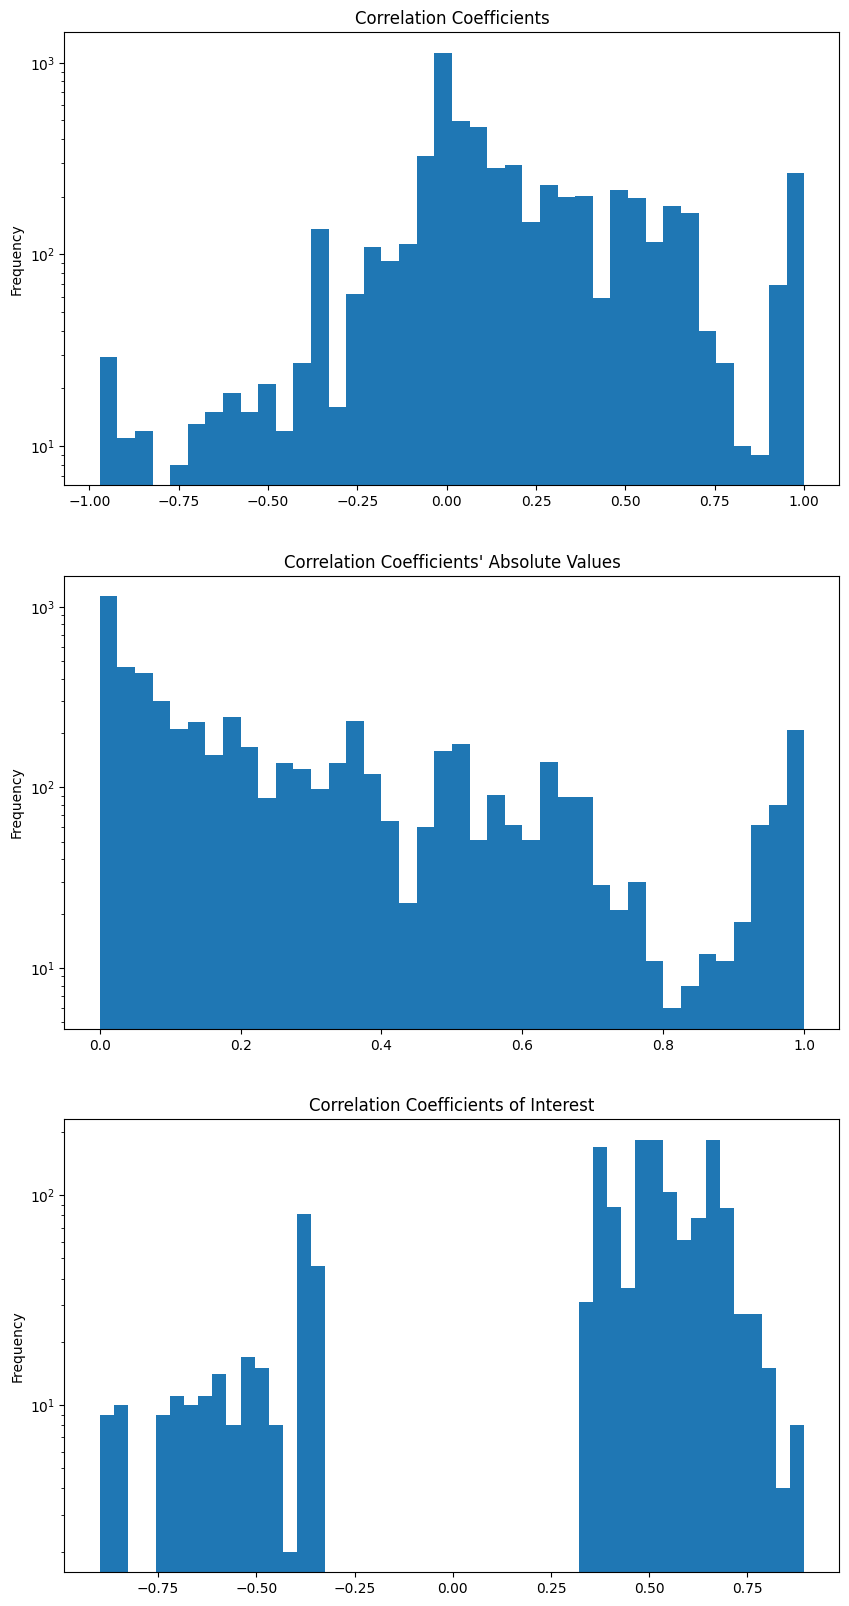

In [160]:
# hate_rate_corr.set_index(["state_name", "division_name", "pug_agency_name"], inplace=True)
extracted_sorted_corrs, extracted_corrs_of_interest = do_corr_analysis(hate_rate_corr, 0.35, 0.9, "state_name|division_name|pug_agency_name")

In [165]:
# look at just the correlations between the hate crime rate and other features
hate_rate_corrs_of_interest = extracted_corrs_of_interest\
                                [(extracted_corrs_of_interest["feature1"] == "transformed_hate_crime_rate")\
                                  | (extracted_corrs_of_interest["feature2"] == "transformed_hate_crime_rate")]\
                                .sort_values(ascending=False, by="abs_corr")\
                                .dropna()\
                                .reset_index()

In [166]:
hate_rate_corrs_of_interest

level_0  index                                           feature1  \
0      2029  11096                        transformed_hate_crime_rate   
1      2033  10880                                    hate_crime_rate   
2      2035  10660                                    hate_crime_rate   
3      2031  11095                        transformed_hate_crime_rate   
4      2037  11106                        transformed_hate_crime_rate   
5      2039  12090                                    hate_crime_rate   
6      2041  11107                        transformed_hate_crime_rate   
7      2043  11870                                    hate_crime_rate   
8      2059   1530  transformed_Percent!!HISPANIC OR LATINO AND RA...   
9      2061  11004                        transformed_hate_crime_rate   
10     2057  11013                        transformed_hate_crime_rate   
11     3025  11099                        transformed_hate_crime_rate   
12     3129    100                                   hate_crime_count   
13     3131  11001                        transformed_hate_crime_rate   
14     3133  11540                                   hate_crime_count   
15     3135  11104                        transformed_hate_crime_rate   
16     3137  11650                                   hate_crime_count   
17     3139  11430                                   hate_crime_count   
18     3141  11003                        transformed_hate_crime_rate   
19     3143    320                                   hate_crime_count   

                                             feature2      corr  abs_corr  
0                                     hate_crime_rate  0.582336  0.582336  
1                         transformed_hate_crime_rate  0.582336  0.582336  
2                         transformed_hate_crime_rate  0.582336  0.582336  
3                                     hate_crime_rate  0.582336  0.582336  
4                                     hate_crime_rate  0.582336  0.582336  
5                         transformed_hate_crime_rate  0.582336  0.582336  
6                                     hate_crime_rate  0.582336  0.582336  
7                         transformed_hate_crime_rate  0.582336  0.582336  
8                         transformed_hate_crime_rate -0.580022  0.580022  
9                        transformed_Total population -0.580022  0.580022  
10  transformed_Percent!!HISPANIC OR LATINO AND RA... -0.580022  0.580022  
11                       transformed_hate_crime_count  0.475093  0.475093  
12                        transformed_hate_crime_rate  0.450231  0.450231  
13                                   hate_crime_count  0.450231  0.450231  
14                        transformed_hate_crime_rate  0.450231  0.450231  
15                                   hate_crime_count  0.450231  0.450231  
16                        transformed_hate_crime_rate  0.450231  0.450231  
17                        transformed_hate_crime_rate  0.450231  0.450231  
18                                   hate_crime_count  0.450231  0.450231  
19                        transformed_hate_crime_rate  0.450231  0.450231

<Axes: title={'center': 'Hate Crime Rate Correlation Coefficient Frequencies'}, ylabel='Frequency'>

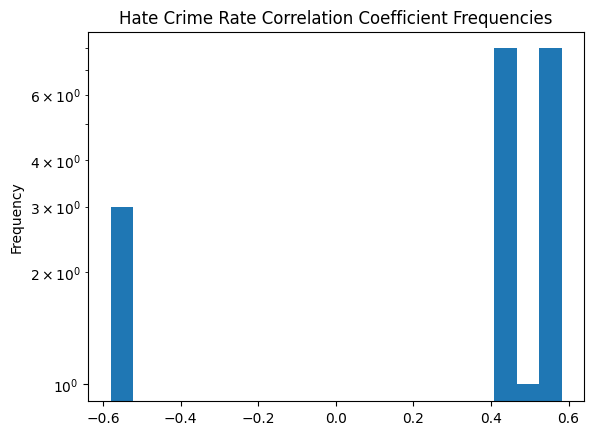

In [163]:
hate_rate_corrs_of_interest['corr'].plot.hist(bins=20, title='Hate Crime Rate Correlation Coefficient Frequencies', logy=True)

####Scatter Plots

In [ ]:
for feature in hate_rate_corrs_of_interest.index:
  county_hate_rates_df.plot.scatter(x=feature, y="transformed_hate_crime_rate")

#Data Prediction

In [ ]:
hate_rate_numerical_cols

In [ ]:
# designate the training data
training_cols = [col for col in hate_rate_numerical_cols if (not "hate_crime_rate" in col) and ("transformed_" in col) and col in county_hate_rates_df.columns]
x_train_df = county_hate_rates_df[training_cols]
y_train_df = county_hate_rates_df["transformed_hate_crime_rate"]
x_train_df.dropna(inplace=True)
y_train_df.dropna(inplace=True)

In [ ]:
x_train_df.head()

In [ ]:
y_train_df.head()

##Hate Crime Rate Regression

MAE, f1-score, sensitivity, specificity
Cross-validation with test sets and k-fold

In [ ]:
# designate a single feature for viewing the model's predictions relative to its transformed value
review_features = "transformed_Percent!!RACE!!One race!!White"
x = pd.DataFrame(x_train_df[review_features])

In [ ]:
x.head()

###Linear Regression on All Transformed Data

Create loadings plot

In [ ]:
hate_regression_model = LinearRegression()
hate_regression_model.fit(
    X=x,
    y=y_train_df
)

In [ ]:
coefficients = hate_regression_model.coef_
intercept = hate_regression_model.intercept_

####Observe regression line for individual feature

In [ ]:
# create a scatter plot of the data
county_hate_rates_df.plot.scatter(x=review_features, y="transformed_hate_crime_rate")

#replace coefficients[0] with coefficients[x_train_df.columns.get_loc(review_features)] if training on x_train_df
y_pred = pd.Series(coefficients[0] * x[review_features])

# plot the line of best fit
plt.plot(x, y_pred)


In [ ]:
lr_rmse = sk.metrics.mean_squared_error(y_train_df, y_pred, squared=False)
lr_mae = sk.metrics.mean_absolute_error(y_train_df, y_pred)
print("Linear Regression RMSE: " + str(lr_rmse))
print("Linear Regression MAE: " + str(lr_mae))

###K-Nearest-Neighbors on Review Feature

In [ ]:
# reformat the training data
x = pd.DataFrame(x_train_df[review_features])

# create the test data
x_test = pd.DataFrame()
x_test[review_features] = np.linspace(-2, 5, len(y_train_df))

errors_by_k_df = pd.DataFrame({
    "k": [np.nan],
    "rmse": [np.nan],
    "mae": [np.nan]
})

increment = 0.05
# try various different values of k
for k in range(20, len(x), 5):
    # create and fit the model
    hate_knn_model = KNeighborsRegressor(n_neighbors=k)
    hate_knn_model.fit(X=x, y=y_train_df)

    # get the model's predictions
    y_pred = pd.Series(
        hate_knn_model.predict(x_test),
        index=x_test[review_features]
    )

    rmse = sk.metrics.mean_squared_error(y_train_df, y_pred, squared=False)
    mae = sk.metrics.mean_absolute_error(y_train_df, y_pred)
    entry = {
        "k": k,
        "rmse": rmse,
        "mae": mae
    }

    errors_by_k_df.loc[len(errors_by_k_df)] = entry

    if (k % int(increment * len(x_train_df)) == 0):
      # plot knn model predictions
      y_pred.plot.line(ylabel="transformed_hate_crime_rate",\
                      label=("k = " + str(k)))\
                      .legend()


errors_by_k_df.dropna(inplace=True)
# errors_by_k_df.set_index("k", inplace=True)

# create a scatter plot of the data
county_hate_rates_df.plot.scatter(x=review_features,\
                                  y="transformed_hate_crime_rate",\
                                  alpha=0.5,\
                                  ylabel="transformed_hate_crime_rate")

# create a scatter plot of the rmse's
errors_by_k_df.plot.line(x="k",\
                       y="rmse",\
                       alpha=0.5,\
                       logy=True,\
                       ylabel="transformed_hate_crime_rate")

In [ ]:
errors_by_k_df.head()

###Comparison of Methods

In [ ]:
best_knn_score_i = errors_by_k_df["mae"].idxmin()

print("Linear Regression Metric Scores:")
print("RMSE:\t\t" + str(lr_rmse))
print("MAE:\t\t" + str(lr_rmse))
print()
print("KNN Metric Scores:")
print("Best k:\t" + str(errors_by_k_df.loc[best_knn_score_i, "k"]))
print("Lowest RMSE:\t" + str(errors_by_k_df.loc[best_knn_score_i, "rmse"]))
print("Lowest MAE:\t" + str(errors_by_k_df.loc[best_knn_score_i, "mae"]))

##Region Classification by Demographics

In [ ]:
classification_df = county_hate_rates_df[training_cols + ["region", "transformed_hate_crime_rate"]]

In [ ]:
region_name_map = {
    0:"Northeast",
    1:"Midwest",
    2:"West",
    3:"South"
}

color_map = {
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'blue',
    5: 'purple'
}

###K-Means Clustering

In [ ]:
classification_df.head()

####Feature selection

In [ ]:
# create the classifier
km_model = KMeans(n_clusters=4, random_state=69)

best_clustering = {
    "features": [],
    "k": 0,
    "silhouette_score": -1
}

In [ ]:
# saved to skip below and reduce future runtime
best_clustering = {
    "features": ['transformed_Percent!!RACE!!One race!!Asian!!Asian Indian',\
                   'transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone'],
    "k": 4,
    "silhouette_score": 0.7786296441943121
}

In [ ]:
# clusterable_feature_pairs = []

# for k in [4]:
#   for i in range(int((4 * len(extracted_sorted_corrs))/8), int((5 * len(extracted_sorted_corrs))/8)):  #len(extracted_sorted_corrs)):
#       row = extracted_sorted_corrs.iloc[i]

#       features = list(row[["feature1", "feature2"]])

#       # create the classifier
#       km_model = KMeans(n_clusters=k, random_state=69)

#       x = classification_df[features + ["region"]]

#       # # fit the classifier to the feature data
#       # km_model.fit(x)

#       # cluster the features
#       predictions = km_model.fit_predict(x)

#       # get the silhouette score
#       silhouette_score = metrics.silhouette_score(x, predictions)

#       # If it's got some pretty good clusters
#       if (silhouette_score > 0.5):
#         clusterable_feature_pairs.append(features)

#         #if it's got good enough clusters, display it
#         if (silhouette_score > 0.9):
#           county_hate_rates_df.plot.scatter(x=row["feature1"],\
#                                       y=row["feature2"],\
#                                       title="Silhouette Score = " + str(silhouette_score),\
#                                       figsize=(12, 12))

#       if (silhouette_score > best_clustering["silhouette_score"]):
#         best_clustering["features"] = features
#         best_clustering["k"] = k
#         best_clustering["silhouette_score"] = silhouette_score


# print("Total clustered feature pairs: " + str(len(clusterable_feature_pairs)))

In [ ]:
print(best_clustering)

In [ ]:
review_features = list(best_clustering["features"])
print(review_features)

####Clustering

In [ ]:
# fit the classifier to the feature best suited to k-means clustering
km_model.fit(classification_df[review_features])

# add the cluster assignment
classification_df['cluster'] = km_model.labels_

In [ ]:
#get the region frequencies associated with each cluster
cluster_regions_df = classification_df\
  .groupby(["cluster", "region"])\
  .size()

cluster_regions_df

In [ ]:
# maps each cluster to a region based on the mode of each cluster
def cluster_region_mapping(cluster_regions_df):
  cluster_region_dict = {}

  # for each cluster and set of associated regions in cluster_regions_df
  for cluster, region_df in cluster_regions_df.groupby(level=0):
    # set that entry of the region map to the most common region membership for classification
    cluster_region_dict[cluster] = region_df.sort_values(ascending=False).index[0][1]

  # return the region mapping dictionary
  return cluster_region_dict

region_map = cluster_region_mapping(cluster_regions_df)
region_map

In [ ]:
#set the k-means predictions for each cluster to the most frequent region membership
classification_df['km_prediction'] = classification_df['cluster'].map(region_map)

#set the k-means predictions for each cluster to the most frequent region membership
classification_df['km_prediction_name'] = classification_df['km_prediction'].map(region_name_map)

In [ ]:
# display the first few rows of the dataframe to verify data
classification_df.head()

In [ ]:
# add a color column to the main df
classification_df['color'] = classification_df['cluster'].map(color_map)

classification_df\
  .groupby('color')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="cluster", logx=True)

In [ ]:
# color clusters by associated cluster
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.5,\
           figsize=(12, 12))

In [ ]:
classification_df\
  .groupby('km_prediction_name')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="predicted region", logx=True)

In [ ]:
# add a color column to the main df
classification_df['color'] = classification_df['km_prediction'].map(color_map)

# color clusters by region majority class
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.5,\
           figsize=(12, 12))

###Naive Bayes

In [ ]:
gnb_model = GaussianNB()

# predict classification_df['cluster'] from classification_df[review_features]
predictions = gnb_model\
                .fit(classification_df[review_features], county_hate_rates_df["region"])\
                .predict(classification_df[review_features])

classification_df["nb_prediction"] = predictions

classification_df["nb_prediction_name"] = pd.Series(predictions).map(region_name_map)

# get the silhouette score of the Naive Bayes classifier's predictions
gnb_silhouette_score = metrics.silhouette_score(classification_df[review_features], predictions)

In [ ]:
print(gnb_silhouette_score)

In [ ]:
classification_df\
  .groupby('nb_prediction_name')\
  .size()\
  .plot\
  .barh(color=sns.palettes.mpl_palette('Dark2'), xlabel="member count", ylabel="region", logx=True)

In [ ]:
classification_df['color'] = classification_df['nb_prediction'].map(color_map)
print("Legend:\n\
        South: Green\n\
        West: Yellow\n\
        Northeast: Red\n\
        Midwest: Orange")

# plot the features under consideration with the colors determined by the naive bayes classifier
classification_df\
  .plot\
  .scatter(x=best_clustering["features"][0],\
           y=best_clustering["features"][1],\
           c="color",\
           alpha=0.25,\
           figsize=(12, 12))

###Compare Clustering/Classification Models

In [ ]:
y_true = county_hate_rates_df["region"]
averaging_method = "macro"

print("K-Means Metric Scores:")
y_pred = classification_df['km_prediction']
print("Silhouette:\t" + str(best_clustering["silhouette_score"]))
print("Accuracy:\t" + str(metrics.accuracy_score(y_true, y_pred)))
print("Precision:\t" + str(metrics.precision_score(y_true, y_pred, average=averaging_method)))
print("Recall:\t\t" + str(metrics.recall_score(y_true, y_pred, average=averaging_method)))
print("F1:\t\t" + str(metrics.f1_score(y_true, y_pred, average=averaging_method)))

print()

print("Naive Bayes Metric Scores:")
y_pred = classification_df["nb_prediction"]
print("Silhouette:\t" + str(gnb_silhouette_score))
print("Accuracy:\t" + str(metrics.accuracy_score(y_true, y_pred)))
print("Precision:\t" + str(metrics.precision_score(y_true, y_pred, average=averaging_method)))
print("Recall:\t\t" + str(metrics.recall_score(y_true, y_pred, average=averaging_method)))
print("F1:\t\t" + str(metrics.f1_score(y_true, y_pred, average=averaging_method)))